In [1]:
import numpy as np
import copy
import os
np.seterr(all='raise') 
import argparse
import csv
import matplotlib
import matplotlib.pyplot as plt
from tqdm import tqdm
import pickle
from datetime import datetime
import scipy
from scipy import stats
from scipy.special import gamma, digamma, loggamma

In [3]:
import os
cwd = os.getcwd()
BOW_PATH = cwd + "/ap/ap.dat" 
VOCAB_PATH = cwd + "/ap/vocab.txt"

'/Users/leon66/Desktop/Machine Learning/STCS 6701 Graphical Models/Project/Code'

In [4]:


# Topic Exch. Dirichlet hyperparameter (mixture components)
ETA = 0.01 # Set to 100/V

# Topic Proportion Dirichlet hyperparameter (mixture proportions)
ALPHA = 0.1 # Set to

# Maximum number of iterations (Might not use)
MAX_ITER = 100

# Number of CAVI iterations
N_TRIALS = 1

# Test data size
N_TEST = 10

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Helper 

In [ ]:
def compute_logsumexp(scores):
    # Take the max of the scores
    max_score = np.max(scores, axis=0)

    # Subtract scores by max and exponentiate
    exp_scores = np.exp(scores - max_score)

    # Compute denominator
    sum_exp = np.sum(exp_scores)

    # Compute log-sum-exp
    log_sum_exp = np.log(sum_exp) + max_score

    return log_sum_exp


# Loads the AP article dataset
def load_data():
    # Load index-to-word mapping
    print('Loading index-to-word mapping...')

    with open(VOCAB_PATH, 'r') as fh:
        raw_lines = fh.readlines()

    idx_to_words = [word.strip() for word in raw_lines]
    V = len(idx_to_words)

    # Load article BoW representations
    print('Loading article bag-of-word representations...')

    with open(BOW_PATH, 'r') as fh:
        raw_lines = fh.readlines()
        N = len(raw_lines)
        print('{} articles found.'.format(N))

    articles = np.zeros((N,V))
    nonzero_idxs = []

    # Process each article
    for i in tqdm(range(N)):
        split = raw_lines[i].split(' ')
        n_words = int(split[0]) # Number of words in the article
        split = split[1:] # BoW representations

        article = np.zeros((V,)) # Sparse V-vector
        nonzero_idx = [] # List of indices that have non-zero counts

        for bow in split:
            bow = bow.strip()
            word_idx, count = bow.split(':')

            nonzero_idx.append(int(word_idx))
            article[int(word_idx)] = count

        # Check if article words parsed correctly
        try:
            assert(len(nonzero_idx) == n_words)
        except:
            raise AssertionError('{}, {}'.format(len(nonzero_idx), n_words))

        articles[i] = article
        nonzero_idxs.append(sorted(nonzero_idx))

    return idx_to_words, articles, nonzero_idxs


# Initializes the variational parameters for CAVI
def init_var_param(train_articles, C):
    print('Initializing variational parameters...')

    # Number of articles, vocabulary size
    N, V = train_articles.shape

    # Topics (initializing LAMBDA for BETA)
    LAMBDA = np.random.uniform(low=0.01, high=1.0, size=(C,V))

    # Topic Proportions (initializing GAMMA for THETA)
    GAMMA = np.ones((N,C)) # Uniform prior

    # Topic Assignments (initializing PHI for Z)
    # Shape: (N,n_words,C) (Note: n_words is vacriable)
    PHI = []

    for article in train_articles:
        n_words = np.sum((article > 0).astype('int32'))
        article_phi = np.ones((n_words,C))
        article_phi = article_phi / C # Initialize to 1/C

        PHI.append(article_phi)

    return LAMBDA, GAMMA, PHI

# Energy Function

In [6]:
def E(p_list,k):
    E = 0
    for i in range(len(p_list) -1):
        E += L(p_list[i]) + 0.5 * k * np.linalg.norm(p_list[i+1] - p_list[i])
    E += 0.5 * k * np.linalg.norm(p_list[-1] - p_list[-2])

    return E

In [7]:
def L(LAMBDA, GAMMA, PHI, train_articles, train_nonzero_idxs, C):
    #compute elbo
    elbo = 0
    
    # Number of articles, vocabulary size
    N, V = train_articles.shape
    
    # Add expected log joint
    ## First term: \sum_{k=1}^C E[log p(BETA_k)]
    E_log_p_beta = 0
    for k in range(C):
        E_log_p_beta += (ETA-1) * np.sum(digamma(LAMBDA[k]) - digamma(np.sum(LAMBDA[k])))
    
    elbo += E_log_p_beta
    
    ## Second term: \sum_{i=1}^N E[log p(THETA_i)]
    E_log_p_theta = 0
    for i in range(N):
        E_log_p_theta += (ALPHA-1) * np.sum(digamma(GAMMA[i]) - digamma(np.sum(GAMMA[i])))

    elbo += E_log_p_theta
    
    ## Third term:
    ## \sum_{i=1}^N \sum_{j=1}^M \sum_{k=1}^C
    ## (E[log p(Z_ij|THETA_i)] + E[log p(X_ij)|BETA,Z_ij)])
    E_log_p_xz = 0
    for i in range(N):
        article = train_articles[i]
        nonzero_idx = train_nonzero_idxs[i]
        
        corr_idx = 0
        for idx in nonzero_idx:
            ### E[log p(Z_ij|THETA_i)]
            E_log_p_xz += article[idx] * np.sum(PHI[i][corr_idx] * (digamma(GAMMA[i]) - digamma(np.sum(GAMMA[i]))))
            
            ### E[log p(X_ij|BETA,Z_ij)]
            E_log_p_xz += article[idx] * np.sum(PHI[i][corr_idx] * (digamma(LAMBDA[:,idx]) - digamma(np.sum(LAMBDA, axis=1))))
            
            corr_idx += 1
        # Check if number of updates match with number of words
        assert(corr_idx == len(nonzero_idx))
        
    elbo += E_log_p_xz
        
    # Add entropy
    ## Fourth term: -\sum_{k=1}^C E[log q(BETA_k)]
    E_log_q_beta = 0
    for k in range(C):
        E_log_q_beta += -loggamma(np.sum(LAMBDA[k])) + np.sum(loggamma(LAMBDA[k]))
        E_log_q_beta += -np.sum((LAMBDA[k]-1) * (digamma(LAMBDA[k]) - digamma(np.sum(LAMBDA[k]))))
    
    elbo += E_log_q_beta
    
    ## Fifth term: -\sum_{i=1}^N E[log q(THETA_i)]
    E_log_q_theta = 0
    for i in range(N):
        E_log_q_theta += -loggamma(np.sum(GAMMA[i])) + np.sum(loggamma(GAMMA[i]))
        E_log_q_theta += -np.sum((GAMMA[i]-1) * (digamma(GAMMA[i]) - digamma(np.sum(GAMMA[i]))))

    elbo += E_log_q_theta
    
    
    ## Sixth term: -\sum_{i=1}^N \sum_{j=1}^M (E[log q(Z_ij)])
    E_log_q_z = 0
    for i in range(N):
        article = train_articles[i]
        nonzero_idx = train_nonzero_idxs[i]

        corr_idx = 0
        for idx in nonzero_idx:
            E_log_q_z += -article[idx] * np.sum(PHI[i][corr_idx] * np.log(PHI[i][corr_idx]))

            corr_idx += 1

        # Check if number of updates match with number of words
        assert(corr_idx == len(nonzero_idx))

    elbo += E_log_q_z

    print('ELBO: {}'.format(elbo))

    return elbo
    

def dLdp(LAMBDA, GAMMA, PHI, train_articles, train_nonzero_idxs, C): 
    predict_flag = False 
    LAMBDA_t = copy.deepcopy(LAMBDA) # Shape: (C,V)
    GAMMA_t = copy.deepcopy(GAMMA) # Shape: (N,C)
    PHI_t = copy.deepcopy(PHI) # Shape: (N,n_words,C)

    N, V = train_articles.shape

    for i in tqdm(range(N)):
        article = train_articles[i]
        nonzero_idx = train_nonzero_idxs[i]

        # Fetch for PHI_ij update
        GAMMA_i_t = copy.deepcopy(GAMMA_t[i]) # C-vector

        # For each word in document
        corr_idx = 0

        # Iterate through each word with non-zero count on document
        for idx in nonzero_idx:
            log_PHI_ij = np.zeros((C,))

            for k in range(C):
                # Fetch for PHI_ij update
                LAMBDA_k_t = copy.deepcopy(LAMBDA_t[k]) # V-vector

                exponent = digamma(GAMMA_i_t[k]) - digamma(np.sum(GAMMA_i_t))
                exponent += digamma(LAMBDA_k_t[idx]) - digamma(np.sum(LAMBDA_k_t))
                log_PHI_ij[k] = exponent

            # Normalize using log-sum-exp trick
            PHI_ij = np.exp(log_PHI_ij - compute_logsumexp(log_PHI_ij))
            try:
                assert(np.abs(np.sum(PHI_ij) - 1) < 1e-6)
            except:
                raise AssertionError('phi_ij: {}, Sum: {}'.format(PHI_ij, np.sum(PHI_ij)))

            PHI_t[i][corr_idx] = PHI_ij
            corr_idx += 1

        # Check if number of updates match with number of words
        assert(corr_idx == len(nonzero_idx))

        # Update GAMMA_i
        GAMMA_i_t = np.zeros((C,)) + ALPHA

        for k in range(C):
            GAMMA_i_t[k] += np.sum(article[nonzero_idx] * PHI_t[i][:,k])

        GAMMA_t[i] = GAMMA_i_t

    if not predict_flag:
        # For each topic
        print('Updating LAMBDA')

        for k in tqdm(range(C)):
            LAMBDA_k_t = np.zeros((V,)) + ETA

            # For each document
            for i in range(N):
                article = train_articles[i]
                nonzero_idx = train_nonzero_idxs[i]

                # For each word in document
                corr_idx = 0

                for idx in nonzero_idx:
                    LAMBDA_k_t[idx] += article[idx] * PHI_t[i][corr_idx][k]
                    corr_idx +=1

                # Check if number of updates match with number of words
                assert(corr_idx == len(nonzero_idx))

            LAMBDA_t[k] = LAMBDA_k_t 
    grad_LAMBDA = LAMBDA_t - LAMBDA
    grad_GAMMA = GAMMA_t - GAMMA 
    grad_PHI = [phi_t - phi for (phi_t,phi) in zip(PHI_t, PHI)]

    return grad_LAMBDA, grad_GAMMA, grad_PHI

In [8]:
def tau(i, p_list, train_articles, train_nonzero_idxs, C):
    #p_list is a list of lists of parameters in which a list is [LAMBDA, GAMMA, PHI] 
    LAMBDA_1, GAMMA_1, PHI_1 = p_list[i] 
    LAMBDA_0, GAMMA_0, PHI_0 = p_list[i-1] 
    LAMBDA_2, GAMMA_2, PHI_2 = p_list[i+1] 

    if compute_elbo( LAMBDA_2, GAMMA_2, PHI_2, train_articles, train_nonzero_idxs, C) > compute_elbo( LAMBDA_0, GAMMA_0, PHI_0 , train_articles, train_nonzero_idxs, C): 
        flat_Lam = np.reshape((LAMBDA_2-LAMBDA_1).flatten(),((LAMBDA_2-LAMBDA_1).flatten().shape[0],1))
        #print(flat_Lam.shape)
        flat_Gam = np.reshape((GAMMA_2 - GAMMA_1).flatten(),((GAMMA_2 - GAMMA_1).flatten().shape[0],1))
        #print(flat_Gam.shape)
        flat_vector = np.vstack((flat_Lam, flat_Gam))
        #print(flat_vector.shape)

        #flat_Phi = (PHI_2-PHI_1).flatten() 
        dif_PHI = [Phi_2-Phi_1 for (Phi_2,Phi_1) in zip(PHI_2,PHI_1)] 
        for dif in dif_PHI: 
            flat_dif = dif.flatten().reshape(dif.flatten().shape[0],1)
            #print(flat_dif.shape)
            flat_vector = np.vstack((flat_vector, flat_dif)) 

        norm = np.linalg.norm(flat_vector)+ 1e-30

        lam_dif = (LAMBDA_2-LAMBDA_1)/norm
        gam_dif = (GAMMA_2 - GAMMA_1)/norm 
        PHI_dif = [dif_phi/norm for dif_phi in dif_PHI]

        return [lam_dif, gam_dif, PHI_dif]
    #TODO: what is the right way to normalize 
    else: 
        flat_Lam = np.reshape((LAMBDA_1-LAMBDA_0).flatten(),((LAMBDA_1-LAMBDA_0).flatten().shape[0],1))
        #print(flat_Lam.shape)
        flat_Gam = np.reshape((GAMMA_1 - GAMMA_0).flatten(),((GAMMA_1 - GAMMA_0).flatten().shape[0],1))
        #print(flat_Gam.shape)
        flat_vector = np.vstack((flat_Lam, flat_Gam))

        #flat_Phi = (PHI_1-PHI_0).flatten() 
        dif_PHI = [Phi_1-Phi_0 for (Phi_1,Phi_0) in zip(PHI_1,PHI_0)] 
        for dif in dif_PHI: 
            flat_dif = dif.flatten().reshape(dif.flatten().shape[0],1)
            flat_vector = np.vstack((flat_vector, flat_dif)) 

        norm = np.linalg.norm(flat_vector)+ 1e-30
        lam_dif = (LAMBDA_1-LAMBDA_0)/norm
        gam_dif = (GAMMA_1 - GAMMA_0)/norm 
        PHI_dif = [dif_phi/norm for dif_phi in dif_PHI]

        return [lam_dif, gam_dif, PHI_dif]
        #return [(LAMBDA_1-LAMBDA_0)/norm, (GAMMA_1 - GAMMA_0)/norm, [dif_phi for dif_phi in dif_PHI/norm]]

In [9]:
def F_L(i, p_list, train_articles, train_nonzero_idxs, C):

  LAMBDA, GAMMA, PHI = p_list[i]
  tau_Lam, tau_Gam, tau_Phi = tau(i, p_list, train_articles, train_nonzero_idxs, C)
  grad_LAMBDA, grad_GAMMA, grad_PHI = dLdp(LAMBDA, GAMMA, PHI, train_articles, train_nonzero_idxs, C)
  grad_dot_tau_Lam = np.multiply(grad_LAMBDA , tau_Lam)
  grad_dot_tau_Gam = np.multiply(grad_GAMMA , tau_Gam)
  grad_dot_tau_Phi = [np.multiply(grad_p ,tau_p) for (grad_p, tau_p) in zip (grad_PHI, tau_Phi)]
  F_L_Lam = -(grad_LAMBDA - grad_dot_tau_Lam*tau_Lam )
  F_L_Gam = -(grad_GAMMA - grad_dot_tau_Gam*tau_Gam )
  F_L_Phi = [-(grad_p - gdt_p*tau_p) for (grad_p, gdt_p, tau_p) in zip (grad_PHI, grad_dot_tau_Phi, tau_Phi) ]
  return F_L_Lam, F_L_Gam, F_L_Phi
  #return -(dLdp(p_list[i]) - np.dot(dLdp(p_list[i]), tau(i, p_list)) *  tau(i, p_list))

def F_s(i, k, p_list):
  LAMBDA_1, GAMMA_1, PHI_1 = p_list[i] 
  LAMBDA_2, GAMMA_2, PHI_2 = p_list[i+1]  
  k_LAMBDA_Diff =  k * (LAMBDA_1 - LAMBDA_2)
  k_GAMMA_Diff =  k * (GAMMA_1 - GAMMA_2)
  k_PHI_Diff = [k*(curr - next) for (curr,next) in zip(PHI_1,PHI_2)]

  return k_LAMBDA_Diff, k_GAMMA_Diff, k_PHI_Diff

In [10]:
def init(theta_1, theta_2, N):
    LAMBDA_1, GAMMA_1, PHI_1 = theta_1
    LAMBDA_2, GAMMA_2, PHI_2 = theta_2

    interval = np.linspace(0,1,N+1)
  
    p_list = []

    for i in interval:
        NEW_LAMBDA = (LAMBDA_2 - LAMBDA_1) * i + LAMBDA_1
        NEW_GAMMA = (GAMMA_2 - GAMMA_1) * i + GAMMA_1
        NEW_PHI = [(Phi_2 - Phi_1) * i + Phi_1 for (Phi_1,Phi_2) in zip(PHI_1,PHI_2)]
        p_list.append([NEW_LAMBDA, NEW_GAMMA, NEW_PHI]) 


    return p_list

##Load data and get parameters 

In [11]:
cwd = os.getcwd()
BOW_PATH = cwd + "/ap/ap.dat" 
VOCAB_PATH = cwd + "/ap/vocab.txt" 

# Topic Exch. Dirichlet hyperparameter (mixture components)
ETA = 0.01 # Set to 100/V

# Topic Proportion Dirichlet hyperparameter (mixture proportions)
ALPHA = 0.1 # Set to

# Maximum number of iterations (Might not use)
MAX_ITER = 100

# Number of CAVI iterations
N_TRIALS = 1

# Test data size
N_TEST = 10

# Computes the softmax for a given set of scores
# Scores will be log probability of each assignment
# Note: Uses log-sum-exp trick to avoid overflow/underflow
def compute_logsumexp(scores):
    # Take the max of the scores
    max_score = np.max(scores, axis=0)

    # Subtract scores by max and exponentiate
    # result = 
    exp_scores = np.exp(scores - max_score)

    # Compute denominator
    sum_exp = np.sum(exp_scores)

    # Compute log-sum-exp
    log_sum_exp = np.log(sum_exp) + max_score

    return log_sum_exp

# Loads the AP article dataset
def load_data():
    # Load index-to-word mapping
    print('Loading index-to-word mapping...')

    with open(VOCAB_PATH, 'r') as fh:
        raw_lines = fh.readlines()

    idx_to_words = [word.strip() for word in raw_lines]
    V = len(idx_to_words)

    # Load article BoW representations
    print('Loading article bag-of-word representations...')

    with open(BOW_PATH, 'r') as fh:
        raw_lines = fh.readlines()
        N = len(raw_lines)
        print('{} articles found.'.format(N))

    articles = np.zeros((N,V))
    nonzero_idxs = []

    # Process each article
    for i in tqdm(range(N)):
        split = raw_lines[i].split(' ')
        n_words = int(split[0]) # Number of words in the article
        split = split[1:] # BoW representations

        article = np.zeros((V,)) # Sparse V-vector
        nonzero_idx = [] # List of indices that have non-zero counts

        for bow in split:
            bow = bow.strip()
            word_idx, count = bow.split(':')

            nonzero_idx.append(int(word_idx))
            article[int(word_idx)] = count

        # Check if article words parsed correctly
        try:
            assert(len(nonzero_idx) == n_words)
        except:
            raise AssertionError('{}, {}'.format(len(nonzero_idx), n_words))

        articles[i] = article
        nonzero_idxs.append(sorted(nonzero_idx))

    return idx_to_words, articles, nonzero_idxs





# Initializes the variational parameters for CAVI
def init_var_param(train_articles, C):
    print('Initializing variational parameters...')

    # Number of articles, vocabulary size
    N, V = train_articles.shape

    # Topics (initializing LAMBDA for BETA)
    LAMBDA = np.random.uniform(low=0.01, high=1.0, size=(C,V))

    # Topic Proportions (initializing GAMMA for THETA)
    GAMMA = np.ones((N,C)) # Uniform prior

    # Topic Assignments (initializing PHI for Z)
    # Shape: (N,n_words,C) (Note: n_words is vacriable)
    PHI = []

    for article in train_articles:
        n_words = np.sum((article > 0).astype('int32'))
        article_phi = np.ones((n_words,C))
        article_phi = article_phi / C # Initialize to 1/C

        PHI.append(article_phi)

    return LAMBDA, GAMMA, PHI

# Compute ELBO
def compute_elbo(LAMBDA, GAMMA, PHI, train_articles, train_nonzero_idxs, C):
    elbo = 0

    # Number of articles, vocabulary size
    N, V = train_articles.shape

    # Add expected log joint
    ## First term: \sum_{k=1}^C E[log p(BETA_k)]
    E_log_p_beta = 0
    for k in range(C):
        E_log_p_beta += (ETA-1) * np.sum(digamma(LAMBDA[k]) - digamma(np.sum(LAMBDA[k])))

    elbo += E_log_p_beta

    ## Second term: \sum_{i=1}^N E[log p(THETA_i)]
    E_log_p_theta = 0
    for i in range(N):
        E_log_p_theta += (ALPHA-1) * np.sum(digamma(GAMMA[i]) - digamma(np.sum(GAMMA[i])))

    elbo += E_log_p_theta

    ## Third term:
    ## \sum_{i=1}^N \sum_{j=1}^M \sum_{k=1}^C
    ## (E[log p(Z_ij|THETA_i)] + E[log p(X_ij)|BETA,Z_ij)])
    E_log_p_xz = 0
    for i in range(N):
        article = train_articles[i]
        nonzero_idx = train_nonzero_idxs[i]

        corr_idx = 0

        for idx in nonzero_idx:
            ### E[log p(Z_ij|THETA_i)]
            E_log_p_xz += article[idx] * np.sum(PHI[i][corr_idx] * (digamma(GAMMA[i]) - digamma(np.sum(GAMMA[i]))))

            ### E[log p(X_ij|BETA,Z_ij)]
            E_log_p_xz += article[idx] * np.sum(PHI[i][corr_idx] * (digamma(LAMBDA[:,idx]) - digamma(np.sum(LAMBDA, axis=1))))

            corr_idx += 1

        # Check if number of updates match with number of words
        assert(corr_idx == len(nonzero_idx))

    elbo += E_log_p_xz

    # Add entropy
    ## Fourth term: -\sum_{k=1}^C E[log q(BETA_k)]
    E_log_q_beta = 0
    for k in range(C):
        E_log_q_beta += -loggamma(np.sum(LAMBDA[k])) + np.sum(loggamma(LAMBDA[k]))
        E_log_q_beta += -np.sum((LAMBDA[k]-1) * (digamma(LAMBDA[k]) - digamma(np.sum(LAMBDA[k]))))

    elbo += E_log_q_beta

    ## Fifth term: -\sum_{i=1}^N E[log q(THETA_i)]
    E_log_q_theta = 0
    for i in range(N):
        E_log_q_theta += -loggamma(np.sum(GAMMA[i])) + np.sum(loggamma(GAMMA[i]))
        E_log_q_theta += -np.sum((GAMMA[i]-1) * (digamma(GAMMA[i]) - digamma(np.sum(GAMMA[i]))))

    elbo += E_log_q_theta

    ## Sixth term: -\sum_{i=1}^N \sum_{j=1}^M (E[log q(Z_ij)])
    E_log_q_z = 0
    for i in range(N):
        article = train_articles[i]
        nonzero_idx = train_nonzero_idxs[i]

        corr_idx = 0
        for idx in nonzero_idx:
            #print(PHI[i][corr_idx])
            #print(type(PHI[i][corr_idx]))
            #print(PHI[i][corr_idx]+1e-1)
            E_log_q_z += -article[idx] * np.sum(PHI[i][corr_idx] * np.log((PHI[i][corr_idx]+1e-2)/(np.linalg.norm(PHI[i][corr_idx]+1e-2)+1e-20)))
            #E_log_q_z += -article[idx] * np.sum(PHI[i][corr_idx] * np.log(np.minimum(PHI[i][corr_idx],1e-9)))/(np.linalg.norm(PHI[i][corr_idx])+1e-20)
            #E_log_q_z += -article[idx] * np.sum(PHI[i][corr_idx] * np.log(np.abs(PHI[i][corr_idx])))

            corr_idx += 1

        # Check if number of updates match with number of words
        assert(corr_idx == len(nonzero_idx))

    elbo += E_log_q_z

    print('ELBO: {}'.format(elbo))

    return elbo

# Runs CAVI for LDA
# TODO: Change max iteration to convergence criterion
def run_cavi(LAMBDA, GAMMA, PHI, train_articles, train_nonzero_idxs, C, max_iter, predict_flag=False):
    # Unpack initial variational parameters
    LAMBDA_t = copy.deepcopy(LAMBDA) # Shape: (C,V)
    GAMMA_t = copy.deepcopy(GAMMA) # Shape: (N,C)
    PHI_t = copy.deepcopy(PHI) # Shape: (N,n_words,C)

    # Number of articles, vocabulary size
    N, V = train_articles.shape

    elbos = []

    print('Running CAVI for LDA (C: {}, Iter: {})...'.format(C, max_iter))
    for t in range(max_iter):
        print('Iteration {}'.format(t+1))
        print('Updating PHI and GAMMA')

        # For each document
        for i in tqdm(range(N)):
            article = train_articles[i]
            nonzero_idx = train_nonzero_idxs[i]

            # Fetch for PHI_ij update
            GAMMA_i_t = copy.deepcopy(GAMMA_t[i]) # C-vector

            # For each word in document
            corr_idx = 0

            # Iterate through each word with non-zero count on document
            for idx in nonzero_idx:
                log_PHI_ij = np.zeros((C,))

                for k in range(C):
                    # Fetch for PHI_ij update
                    LAMBDA_k_t = copy.deepcopy(LAMBDA_t[k]) # V-vector

                    exponent = digamma(GAMMA_i_t[k]) - digamma(np.sum(GAMMA_i_t))
                    exponent += digamma(LAMBDA_k_t[idx]) - digamma(np.sum(LAMBDA_k_t))
                    log_PHI_ij[k] = exponent

                # Normalize using log-sum-exp trick
                PHI_ij = np.exp(log_PHI_ij - compute_logsumexp(log_PHI_ij))
                try:
                    assert(np.abs(np.sum(PHI_ij) - 1) < 1e-6)
                except:
                    raise AssertionError('phi_ij: {}, Sum: {}'.format(PHI_ij, np.sum(PHI_ij)))

                PHI_t[i][corr_idx] = PHI_ij
                corr_idx += 1

            # Check if number of updates match with number of words
            assert(corr_idx == len(nonzero_idx))

            # Update GAMMA_i
            GAMMA_i_t = np.zeros((C,)) + ALPHA

            for k in range(C):
                GAMMA_i_t[k] += np.sum(article[nonzero_idx] * PHI_t[i][:,k])

            GAMMA_t[i] = GAMMA_i_t

        if not predict_flag:
            # For each topic
            print('Updating LAMBDA')

            for k in tqdm(range(C)):
                LAMBDA_k_t = np.zeros((V,)) + ETA

                # For each document
                for i in range(N):
                    article = train_articles[i]
                    nonzero_idx = train_nonzero_idxs[i]

                    # For each word in document
                    corr_idx = 0

                    for idx in nonzero_idx:
                        LAMBDA_k_t[idx] += article[idx] * PHI_t[i][corr_idx][k]
                        corr_idx +=1

                    # Check if number of updates match with number of words
                    assert(corr_idx == len(nonzero_idx))

                LAMBDA_t[k] = LAMBDA_k_t

        # Compute ELBO
        elbo = compute_elbo(LAMBDA_t, GAMMA_t, PHI_t, train_articles, train_nonzero_idxs, C)
        elbos.append(elbo)

    LAMBDA_final = copy.deepcopy(LAMBDA_t)
    GAMMA_final = copy.deepcopy(GAMMA_t)
    PHI_final = copy.deepcopy(PHI_t)

    return LAMBDA_final, GAMMA_final, PHI_final, elbos

def filter_train_words(idx_to_words, train_nonzero_idxs):
    # Number of train articles, vocabulary size
    N, V = train_articles.shape

    train_word_idxs = []

    for i in range(N):

        nonzero_idx = train_nonzero_idxs[i]
        train_word_idxs += nonzero_idx

    train_word_idxs = set(train_word_idxs)
    test_word_idxs = set(range(V)) - train_word_idxs

    return test_word_idxs

# Computes the predictive likelihood score on held out articles
def compute_pred_score(LAMBDA, GAMMA, PHI, test_articles, test_nonzero_idxs, test_word_idxs):
    # Number of test articles, vocabulary size
    N,V = test_articles.shape

    C = LAMBDA.shape[0]

    # Expected BETA
    BETA = np.zeros((C,V))

    for k in range(C):
        BETA[k] = LAMBDA[k] / np.sum(LAMBDA[k])

    # Expected THETA
    THETA = np.zeros((N,C))

    for i in range(N):
        THETA[i] = GAMMA[i] / np.sum(GAMMA[i])

    # Compute predictive likelihood
    print('Computing predictive likelihood score on held out documents...')

    score = 0
    for i in tqdm(range(N)):
        article = test_articles[i]
        nonzero_idx = test_nonzero_idxs[i]

        for idx in nonzero_idx:
            if not idx in test_word_idxs:
                score += np.log(np.dot(THETA[i], BETA[:,idx]))

    print('Predictive likelihood: {}'.format(score))

    return score



In [12]:
cwd = os.getcwd()
BOW_PATH = cwd + "/ap/ap.dat" 
VOCAB_PATH = cwd + "/ap/vocab.txt"

#load_data 

def load_data(BOW_PATH,VOCAB_PATH, trim):
    # Load index-to-word mapping
    print('Loading index-to-word mapping...')

    with open(VOCAB_PATH, 'r') as fh:
        raw_lines = fh.readlines()

    idx_to_words = [word.strip() for word in raw_lines]
    V = len(idx_to_words)

    # Load article BoW representations
    print('Loading article bag-of-word representations...')

    with open(BOW_PATH, 'r') as fh:
        raw_lines = fh.readlines()
        raw_lines = raw_lines[:np.int(trim*len(raw_lines))]
        N = len(raw_lines)
        print('{} articles found.'.format(N))

    articles = np.zeros((N,V))
    nonzero_idxs = []

    # Process each article
    for i in tqdm(range(N)):
        split = raw_lines[i].split(' ')
        n_words = int(split[0]) # Number of words in the article
        split = split[1:] # BoW representations

        article = np.zeros((V,)) # Sparse V-vector
        nonzero_idx = [] # List of indices that have non-zero counts

        for bow in split:
            bow = bow.strip()
            word_idx, count = bow.split(':')

            nonzero_idx.append(int(word_idx))
            article[int(word_idx)] = count

        # Check if article words parsed correctly
        try:
            assert(len(nonzero_idx) == n_words)
        except:
            raise AssertionError('{}, {}'.format(len(nonzero_idx), n_words))

        articles[i] = article
        nonzero_idxs.append(sorted(nonzero_idx))

    return idx_to_words, articles, nonzero_idxs

In [13]:
pred_score_list = []

/var/folders/mw/9bfg1rf52g57tm0mgxqjy4gm0000gn/T/ipykernel_68884/2614035497.py:22: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  raw_lines = raw_lines[:np.int(trim*len(raw_lines))]


Loading AP article data...
Loading index-to-word mapping...
Loading article bag-of-word representations...
22 articles found.


100%|█████████████████████████████████████████| 22/22 [00:00<00:00, 9170.61it/s]


Running LDA CAVI 1/1...
Initializing variational parameters...
Running CAVI for LDA (C: 10, Iter: 20)...
Iteration 1
Updating PHI and GAMMA


100%|███████████████████████████████████████████| 12/12 [00:00<00:00, 72.66it/s]


Updating LAMBDA


100%|█████████████████████████████████████████| 10/10 [00:00<00:00, 2014.94it/s]


ELBO: 440531.77297408634
Iteration 2
Updating PHI and GAMMA


100%|███████████████████████████████████████████| 12/12 [00:00<00:00, 74.51it/s]


Updating LAMBDA


100%|█████████████████████████████████████████| 10/10 [00:00<00:00, 2134.51it/s]


ELBO: 448449.59832922404
Iteration 3
Updating PHI and GAMMA


100%|███████████████████████████████████████████| 12/12 [00:00<00:00, 73.11it/s]


Updating LAMBDA


100%|█████████████████████████████████████████| 10/10 [00:00<00:00, 2096.84it/s]


ELBO: 453082.8300580096
Iteration 4
Updating PHI and GAMMA


100%|███████████████████████████████████████████| 12/12 [00:00<00:00, 71.70it/s]


Updating LAMBDA


100%|█████████████████████████████████████████| 10/10 [00:00<00:00, 2215.46it/s]


ELBO: 455496.8252086082
Iteration 5
Updating PHI and GAMMA


100%|███████████████████████████████████████████| 12/12 [00:00<00:00, 73.00it/s]


Updating LAMBDA


100%|█████████████████████████████████████████| 10/10 [00:00<00:00, 1874.38it/s]


ELBO: 456866.2931464062
Iteration 6
Updating PHI and GAMMA


100%|███████████████████████████████████████████| 12/12 [00:00<00:00, 73.15it/s]


Updating LAMBDA


100%|█████████████████████████████████████████| 10/10 [00:00<00:00, 2070.03it/s]


ELBO: 457643.1973476615
Iteration 7
Updating PHI and GAMMA


100%|███████████████████████████████████████████| 12/12 [00:00<00:00, 73.05it/s]


Updating LAMBDA


100%|█████████████████████████████████████████| 10/10 [00:00<00:00, 1953.84it/s]


ELBO: 458073.7417835055
Iteration 8
Updating PHI and GAMMA


100%|███████████████████████████████████████████| 12/12 [00:00<00:00, 71.62it/s]


Updating LAMBDA


100%|█████████████████████████████████████████| 10/10 [00:00<00:00, 2036.76it/s]


ELBO: 458328.67970743554
Iteration 9
Updating PHI and GAMMA


100%|███████████████████████████████████████████| 12/12 [00:00<00:00, 72.38it/s]


Updating LAMBDA


100%|█████████████████████████████████████████| 10/10 [00:00<00:00, 1880.85it/s]


ELBO: 458488.1550604201
Iteration 10
Updating PHI and GAMMA


100%|███████████████████████████████████████████| 12/12 [00:00<00:00, 71.57it/s]


Updating LAMBDA


100%|█████████████████████████████████████████| 10/10 [00:00<00:00, 2162.24it/s]


ELBO: 458579.5294741149
Iteration 11
Updating PHI and GAMMA


100%|███████████████████████████████████████████| 12/12 [00:00<00:00, 73.14it/s]


Updating LAMBDA


100%|█████████████████████████████████████████| 10/10 [00:00<00:00, 2305.07it/s]


ELBO: 458654.6790318839
Iteration 12
Updating PHI and GAMMA


100%|███████████████████████████████████████████| 12/12 [00:00<00:00, 74.69it/s]


Updating LAMBDA


100%|█████████████████████████████████████████| 10/10 [00:00<00:00, 2166.93it/s]


ELBO: 458690.3713738461
Iteration 13
Updating PHI and GAMMA


100%|███████████████████████████████████████████| 12/12 [00:00<00:00, 75.10it/s]


Updating LAMBDA


100%|█████████████████████████████████████████| 10/10 [00:00<00:00, 1893.93it/s]


ELBO: 458713.0435232305
Iteration 14
Updating PHI and GAMMA


100%|███████████████████████████████████████████| 12/12 [00:00<00:00, 73.59it/s]


Updating LAMBDA


100%|█████████████████████████████████████████| 10/10 [00:00<00:00, 2055.63it/s]


ELBO: 458734.2487497465
Iteration 15
Updating PHI and GAMMA


100%|███████████████████████████████████████████| 12/12 [00:00<00:00, 74.09it/s]


Updating LAMBDA


100%|█████████████████████████████████████████| 10/10 [00:00<00:00, 2201.16it/s]


ELBO: 458753.8020501399
Iteration 16
Updating PHI and GAMMA


100%|███████████████████████████████████████████| 12/12 [00:00<00:00, 74.31it/s]


Updating LAMBDA


100%|█████████████████████████████████████████| 10/10 [00:00<00:00, 2273.21it/s]


ELBO: 458762.4070589972
Iteration 17
Updating PHI and GAMMA


100%|███████████████████████████████████████████| 12/12 [00:00<00:00, 73.10it/s]


Updating LAMBDA


100%|█████████████████████████████████████████| 10/10 [00:00<00:00, 1969.25it/s]


ELBO: 458768.7378062612
Iteration 18
Updating PHI and GAMMA


100%|███████████████████████████████████████████| 12/12 [00:00<00:00, 74.09it/s]


Updating LAMBDA


100%|█████████████████████████████████████████| 10/10 [00:00<00:00, 2208.92it/s]


ELBO: 458774.3052909131
Iteration 19
Updating PHI and GAMMA


100%|███████████████████████████████████████████| 12/12 [00:00<00:00, 74.31it/s]


Updating LAMBDA


100%|█████████████████████████████████████████| 10/10 [00:00<00:00, 2091.61it/s]


ELBO: 458780.46125569334
Iteration 20
Updating PHI and GAMMA


100%|███████████████████████████████████████████| 12/12 [00:00<00:00, 74.00it/s]


Updating LAMBDA


100%|█████████████████████████████████████████| 10/10 [00:00<00:00, 2214.76it/s]


ELBO: 458787.2395895142


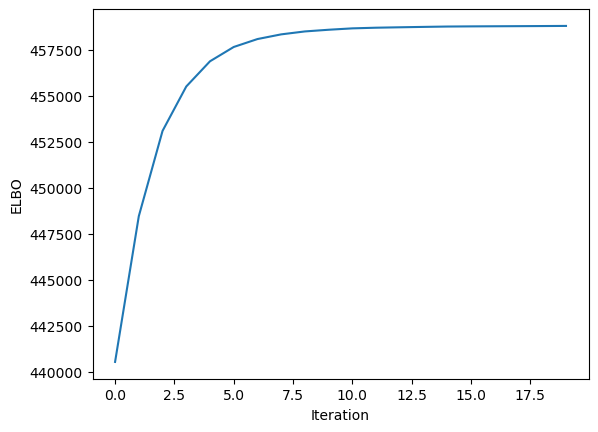

ELBO plot saved.
Initializing variational parameters...
Running CAVI for LDA (C: 10, Iter: 20)...
Iteration 1
Updating PHI and GAMMA


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 71.68it/s]


ELBO: 349331.36100934475
Iteration 2
Updating PHI and GAMMA


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 73.26it/s]


ELBO: 349416.01679169066
Iteration 3
Updating PHI and GAMMA


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 70.89it/s]


ELBO: 349489.2828863235
Iteration 4
Updating PHI and GAMMA


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 73.37it/s]


ELBO: 349542.3478982725
Iteration 5
Updating PHI and GAMMA


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 72.89it/s]


ELBO: 349578.131822762
Iteration 6
Updating PHI and GAMMA


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 73.48it/s]


ELBO: 349601.9091984133
Iteration 7
Updating PHI and GAMMA


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 73.11it/s]


ELBO: 349618.6384474508
Iteration 8
Updating PHI and GAMMA


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 71.83it/s]


ELBO: 349630.17949262797
Iteration 9
Updating PHI and GAMMA


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 71.64it/s]


ELBO: 349637.8962485091
Iteration 10
Updating PHI and GAMMA


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 72.10it/s]


ELBO: 349643.4319987707
Iteration 11
Updating PHI and GAMMA


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 71.81it/s]


ELBO: 349647.53086192475
Iteration 12
Updating PHI and GAMMA


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 72.04it/s]


ELBO: 349650.6024480381
Iteration 13
Updating PHI and GAMMA


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 72.24it/s]


ELBO: 349652.929807273
Iteration 14
Updating PHI and GAMMA


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 72.55it/s]


ELBO: 349654.71128378547
Iteration 15
Updating PHI and GAMMA


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 71.77it/s]


ELBO: 349656.0875852959
Iteration 16
Updating PHI and GAMMA


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 72.27it/s]


ELBO: 349657.1597599155
Iteration 17
Updating PHI and GAMMA


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 72.21it/s]


ELBO: 349658.00125072163
Iteration 18
Updating PHI and GAMMA


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 72.37it/s]


ELBO: 349658.66606233973
Iteration 19
Updating PHI and GAMMA


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 71.80it/s]


ELBO: 349659.19435217284
Iteration 20
Updating PHI and GAMMA


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 73.17it/s]


ELBO: 349659.6162995698
Computing predictive likelihood score on held out documents...


100%|████████████████████████████████████████| 10/10 [00:00<00:00, 12768.05it/s]

Predictive likelihood: -2818.893713904983
Total run-time: 0:0:8


<Figure size 640x480 with 0 Axes>

In [14]:
C = 10 #num of topics 
#use_cached = kwargs['use_cached']
predict_flag = True
max_iter = 20
n_trials = 1
trim = 0.01

start_time = datetime.now()

global ALPHA
ALPHA = 1 / C

# Load data
print('Loading AP article data...')
idx_to_words, articles, nonzero_idxs = load_data(BOW_PATH,VOCAB_PATH, trim)

# Split data into train/test

train_articles = articles[:-N_TEST]
train_nonzero_idxs = nonzero_idxs[:-N_TEST]
test_articles = articles[-N_TEST:]
test_nonzero_idxs = nonzero_idxs[-N_TEST:]

#var_param_dict = {}
colors = matplotlib.cm.tab10(np.linspace(0,1,n_trials))
best_trial = 0
best_elbo = -np.inf

for trial in range(n_trials):
    print('Running LDA CAVI {}/{}...'.format(trial+1, n_trials))

    # Initialize variational parameters
    LAMBDA, GAMMA, PHI = init_var_param(train_articles, C)

    # Run CAVI
    LAMBDA_final, GAMMA_final, PHI_final, elbos = run_cavi(LAMBDA, GAMMA, PHI, train_articles,
                                                            train_nonzero_idxs, C, max_iter)

    elbo_final = elbos[-1]

    if elbo_final > best_elbo:
        best_trial = trial
        best_elbo = elbo_final
        
    '''
    var_param_dict[trial] = {'LAMBDA': LAMBDA_final,
                              'GAMMA': GAMMA_final,
                              'PHI': PHI_final,
                              'elbos': elbos}
    '''
    # Plot ELBO
    plt.plot(np.arange(0, max_iter), elbos, label=trial+1, color=colors[trial])

#plt.legend()
plt.xlabel('Iteration')
plt.ylabel('ELBO')
plt.show()
plt.savefig('./elbo_plot_{}_{}.png'.format(C, max_iter))
print('ELBO plot saved.')

# Compute predictive likelihood score on held out test articles
if predict_flag:
    
    #LAMBDA_fixed = var_param_dict[best_trial]['LAMBDA']
    LAMBDA_fixed = LAMBDA_final

    # Initialize variational parameters
    _, GAMMA, PHI = init_var_param(test_articles, C)

    # Run CAVI
    LAMBDA_pred, GAMMA_pred, PHI_pred, elbos = run_cavi(LAMBDA_fixed, GAMMA, PHI, test_articles,
                                                        test_nonzero_idxs, C, max_iter, predict_flag=True)
    test_word_idxs = []
    # Compute predictive likelihood
    test_word_idxs = filter_train_words(idx_to_words, train_nonzero_idxs)
    pred_score = compute_pred_score(LAMBDA_pred, GAMMA_pred, PHI_pred, test_articles,
                                    test_nonzero_idxs, test_word_idxs)
    #var_param_dict['score'] = pred_score
    pred_score_list.append(pred_score)

# Save inferred variational parameters
'''
with open('var_params_{}_{}.pkl'.format(C, max_iter), 'wb') as fh:
    pickle.dump(var_param_dict, fh)
    print('Inferred variational parameters saved.')
'''

end_time = datetime.now()
elapsed_time = end_time - start_time
hours, rem = divmod(elapsed_time.seconds, 3600)
minutes, seconds = divmod(rem, 60)
print('Total run-time: {}:{}:{}'.format(hours, minutes, seconds))


In [16]:
theta1 = [LAMBDA_final, GAMMA_final, PHI_final] 

In [17]:
theta1[0].shape

(10, 10473)

In [18]:
theta1[1].shape

(12, 10)

In [19]:
theta1[2][4].shape

(56, 10)

Loading AP article data...
Loading index-to-word mapping...
Loading article bag-of-word representations...


<ipython-input-15-01e11dda9d27>:21: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  raw_lines = raw_lines[:np.int(trim*len(raw_lines))]


22 articles found.


100%|██████████| 22/22 [00:00<00:00, 1928.70it/s]


Running LDA CAVI 1/1...
Initializing variational parameters...
Running CAVI for LDA (C: 10, Iter: 20)...
Iteration 1
Updating PHI and GAMMA


100%|██████████| 12/12 [00:00<00:00, 15.85it/s]


Updating LAMBDA


100%|██████████| 10/10 [00:00<00:00, 331.69it/s]


ELBO: 440621.13079878245
Iteration 2
Updating PHI and GAMMA


100%|██████████| 12/12 [00:00<00:00, 17.53it/s]


Updating LAMBDA


100%|██████████| 10/10 [00:00<00:00, 306.83it/s]


ELBO: 448473.3229804881
Iteration 3
Updating PHI and GAMMA


100%|██████████| 12/12 [00:00<00:00, 18.57it/s]


Updating LAMBDA


100%|██████████| 10/10 [00:00<00:00, 234.76it/s]


ELBO: 453122.34985586704
Iteration 4
Updating PHI and GAMMA


100%|██████████| 12/12 [00:00<00:00, 12.23it/s]


Updating LAMBDA


100%|██████████| 10/10 [00:00<00:00, 199.46it/s]


ELBO: 455472.597583646
Iteration 5
Updating PHI and GAMMA


100%|██████████| 12/12 [00:00<00:00, 16.45it/s]


Updating LAMBDA


100%|██████████| 10/10 [00:00<00:00, 357.17it/s]


ELBO: 456806.16847825685
Iteration 6
Updating PHI and GAMMA


100%|██████████| 12/12 [00:00<00:00, 12.17it/s]


Updating LAMBDA


100%|██████████| 10/10 [00:00<00:00, 370.70it/s]


ELBO: 457622.1581713324
Iteration 7
Updating PHI and GAMMA


100%|██████████| 12/12 [00:00<00:00, 22.74it/s]


Updating LAMBDA


100%|██████████| 10/10 [00:00<00:00, 579.88it/s]


ELBO: 458053.02233631694
Iteration 8
Updating PHI and GAMMA


100%|██████████| 12/12 [00:00<00:00, 12.12it/s]


Updating LAMBDA


100%|██████████| 10/10 [00:00<00:00, 234.55it/s]


ELBO: 458333.65443272906
Iteration 9
Updating PHI and GAMMA


100%|██████████| 12/12 [00:00<00:00, 16.03it/s]


Updating LAMBDA


100%|██████████| 10/10 [00:00<00:00, 282.03it/s]


ELBO: 458490.90767574526
Iteration 10
Updating PHI and GAMMA


100%|██████████| 12/12 [00:00<00:00, 15.97it/s]


Updating LAMBDA


100%|██████████| 10/10 [00:00<00:00, 444.02it/s]


ELBO: 458601.0086288973
Iteration 11
Updating PHI and GAMMA


100%|██████████| 12/12 [00:00<00:00, 20.22it/s]


Updating LAMBDA


100%|██████████| 10/10 [00:00<00:00, 312.70it/s]


ELBO: 458670.76360894635
Iteration 12
Updating PHI and GAMMA


100%|██████████| 12/12 [00:00<00:00, 14.38it/s]


Updating LAMBDA


100%|██████████| 10/10 [00:00<00:00, 504.27it/s]


ELBO: 458716.13875191414
Iteration 13
Updating PHI and GAMMA


100%|██████████| 12/12 [00:00<00:00, 21.50it/s]


Updating LAMBDA


100%|██████████| 10/10 [00:00<00:00, 181.32it/s]


ELBO: 458737.68459070317
Iteration 14
Updating PHI and GAMMA


100%|██████████| 12/12 [00:00<00:00, 18.15it/s]


Updating LAMBDA


100%|██████████| 10/10 [00:00<00:00, 328.02it/s]


ELBO: 458754.53281281056
Iteration 15
Updating PHI and GAMMA


100%|██████████| 12/12 [00:00<00:00, 12.84it/s]


Updating LAMBDA


100%|██████████| 10/10 [00:00<00:00, 344.00it/s]


ELBO: 458771.1373051799
Iteration 16
Updating PHI and GAMMA


100%|██████████| 12/12 [00:00<00:00, 23.79it/s]


Updating LAMBDA


100%|██████████| 10/10 [00:00<00:00, 583.90it/s]


ELBO: 458777.639424758
Iteration 17
Updating PHI and GAMMA


100%|██████████| 12/12 [00:00<00:00, 23.57it/s]


Updating LAMBDA


100%|██████████| 10/10 [00:00<00:00, 573.59it/s]


ELBO: 458786.0758908338
Iteration 18
Updating PHI and GAMMA


100%|██████████| 12/12 [00:00<00:00, 26.56it/s]


Updating LAMBDA


100%|██████████| 10/10 [00:00<00:00, 739.40it/s]


ELBO: 458790.9178081038
Iteration 19
Updating PHI and GAMMA


100%|██████████| 12/12 [00:00<00:00, 25.50it/s]


Updating LAMBDA


100%|██████████| 10/10 [00:00<00:00, 586.41it/s]


ELBO: 458795.6849169759
Iteration 20
Updating PHI and GAMMA


100%|██████████| 12/12 [00:00<00:00, 26.01it/s]


Updating LAMBDA


100%|██████████| 10/10 [00:00<00:00, 509.53it/s]


ELBO: 458796.8835886078


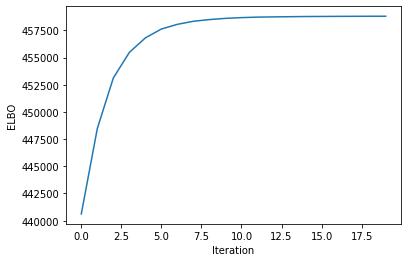

ELBO plot saved.
Initializing variational parameters...
Running CAVI for LDA (C: 10, Iter: 20)...
Iteration 1
Updating PHI and GAMMA


100%|██████████| 10/10 [00:00<00:00, 27.34it/s]


ELBO: 349299.7605798504
Iteration 2
Updating PHI and GAMMA


100%|██████████| 10/10 [00:00<00:00, 24.42it/s]


ELBO: 349378.26981983136
Iteration 3
Updating PHI and GAMMA


100%|██████████| 10/10 [00:00<00:00, 22.46it/s]


ELBO: 349446.7260695837
Iteration 4
Updating PHI and GAMMA


100%|██████████| 10/10 [00:00<00:00, 25.25it/s]


ELBO: 349495.4563461669
Iteration 5
Updating PHI and GAMMA


100%|██████████| 10/10 [00:00<00:00, 24.84it/s]


ELBO: 349527.84493941115
Iteration 6
Updating PHI and GAMMA


100%|██████████| 10/10 [00:00<00:00, 24.51it/s]


ELBO: 349549.50116188976
Iteration 7
Updating PHI and GAMMA


100%|██████████| 10/10 [00:00<00:00, 20.83it/s]


ELBO: 349563.68427994754
Iteration 8
Updating PHI and GAMMA


100%|██████████| 10/10 [00:00<00:00, 14.33it/s]


ELBO: 349573.3460733653
Iteration 9
Updating PHI and GAMMA


100%|██████████| 10/10 [00:00<00:00, 11.61it/s]


ELBO: 349579.4496687685
Iteration 10
Updating PHI and GAMMA


100%|██████████| 10/10 [00:00<00:00, 25.64it/s]


ELBO: 349583.4652410002
Iteration 11
Updating PHI and GAMMA


100%|██████████| 10/10 [00:00<00:00, 25.01it/s]


ELBO: 349586.2560564489
Iteration 12
Updating PHI and GAMMA


100%|██████████| 10/10 [00:00<00:00, 26.14it/s]


ELBO: 349588.2105896662
Iteration 13
Updating PHI and GAMMA


100%|██████████| 10/10 [00:00<00:00, 24.75it/s]


ELBO: 349589.5892867691
Iteration 14
Updating PHI and GAMMA


100%|██████████| 10/10 [00:00<00:00, 25.21it/s]


ELBO: 349590.56881197594
Iteration 15
Updating PHI and GAMMA


100%|██████████| 10/10 [00:00<00:00, 23.46it/s]


ELBO: 349591.26980103663
Iteration 16
Updating PHI and GAMMA


100%|██████████| 10/10 [00:00<00:00, 27.00it/s]


ELBO: 349591.775168071
Iteration 17
Updating PHI and GAMMA


100%|██████████| 10/10 [00:00<00:00, 24.77it/s]


ELBO: 349592.14226305735
Iteration 18
Updating PHI and GAMMA


100%|██████████| 10/10 [00:00<00:00, 26.17it/s]


ELBO: 349592.4109999222
Iteration 19
Updating PHI and GAMMA


100%|██████████| 10/10 [00:00<00:00, 25.44it/s]


ELBO: 349592.60932649014
Iteration 20
Updating PHI and GAMMA


100%|██████████| 10/10 [00:00<00:00, 26.56it/s]


ELBO: 349592.75692897773
Computing predictive likelihood score on held out documents...


100%|██████████| 10/10 [00:00<00:00, 2926.94it/s]

Predictive likelihood: -2823.884738478613
Total run-time: 0:0:32


<Figure size 432x288 with 0 Axes>

In [ ]:
'''
C = 10 #num of topics 
#use_cached = kwargs['use_cached']
predict_flag = True
max_iter = 20
n_trials = 1
trim = 0.01

start_time = datetime.now()

global ALPHA
ALPHA = 1 / C

# Load data
print('Loading AP article data...')
idx_to_words, articles, nonzero_idxs = load_data(BOW_PATH,VOCAB_PATH, trim)

# Split data into train/test

train_articles = articles[:-N_TEST]
train_nonzero_idxs = nonzero_idxs[:-N_TEST]
test_articles = articles[-N_TEST:]
test_nonzero_idxs = nonzero_idxs[-N_TEST:]
'''

#var_param_dict = {}
colors = matplotlib.cm.tab10(np.linspace(0,1,n_trials))
best_trial = 0
best_elbo = -np.inf

for trial in range(n_trials):
    print('Running LDA CAVI {}/{}...'.format(trial+1, n_trials))

    # Initialize variational parameters
    LAMBDA, GAMMA, PHI = init_var_param(train_articles, C)

    # Run CAVI
    LAMBDA_final, GAMMA_final, PHI_final, elbos = run_cavi(LAMBDA, GAMMA, PHI, train_articles,
                                                            train_nonzero_idxs, C, max_iter)

    elbo_final = elbos[-1]

    if elbo_final > best_elbo:
        best_trial = trial
        best_elbo = elbo_final
        
    '''
    var_param_dict[trial] = {'LAMBDA': LAMBDA_final,
                              'GAMMA': GAMMA_final,
                              'PHI': PHI_final,
                              'elbos': elbos}
    '''
    # Plot ELBO
    plt.plot(np.arange(0, max_iter), elbos, label=trial+1, color=colors[trial])

#plt.legend()
plt.xlabel('Iteration')
plt.ylabel('ELBO')
plt.show()
plt.savefig('./elbo_plot_{}_{}.png'.format(C, max_iter))
print('ELBO plot saved.')

# Compute predictive likelihood score on held out test articles
if predict_flag:
    
    #LAMBDA_fixed = var_param_dict[best_trial]['LAMBDA']
    LAMBDA_fixed = LAMBDA_final

    # Initialize variational parameters
    _, GAMMA, PHI = init_var_param(test_articles, C)

    # Run CAVI
    LAMBDA_pred, GAMMA_pred, PHI_pred, elbos = run_cavi(LAMBDA_fixed, GAMMA, PHI, test_articles,
                                                        test_nonzero_idxs, C, max_iter, predict_flag=True)
    test_word_idxs = []
    # Compute predictive likelihood
    test_word_idxs = filter_train_words(idx_to_words, train_nonzero_idxs)
    pred_score = compute_pred_score(LAMBDA_pred, GAMMA_pred, PHI_pred, test_articles,
                                    test_nonzero_idxs, test_word_idxs)
    #var_param_dict['score'] = pred_score
    pred_score_list.append(pred_score)

# Save inferred variational parameters
'''
with open('var_params_{}_{}.pkl'.format(C, max_iter), 'wb') as fh:
    pickle.dump(var_param_dict, fh)
    print('Inferred variational parameters saved.')
'''

end_time = datetime.now()
elapsed_time = end_time - start_time
hours, rem = divmod(elapsed_time.seconds, 3600)
minutes, seconds = divmod(rem, 60)
print('Total run-time: {}:{}:{}'.format(hours, minutes, seconds))


In [ ]:
theta2 = [LAMBDA_final, GAMMA_final, PHI_final] 

In [ ]:
theta2[1].shape

(12, 10)

In [ ]:
theta1[1].shape

(12, 10)

###what are the most probable words? 

theta1

In [ ]:
most_freq_words_1 = [] 

for k in range(C): 
  row = theta1[0][k] 
  ind = np.argpartition(row, -10)[-10:] 
  words = []
  for i in ind: 
    words.append(idx_to_words[i])
  most_freq_words_1.append(words)

In [ ]:
most_freq_words_1

[['panamanian',
  'think',
  'japan',
  'jackson',
  'bechtel',
  'back',
  'ministry',
  'american',
  'skins',
  'teacher'],
 ['world',
  'pastor',
  'value',
  'illegal',
  'important',
  'attorney',
  'export',
  'offer',
  'israel',
  'foreign'],
 ['gunman',
  'trade',
  'bloomberg',
  'take',
  'million',
  'get',
  'year',
  'monday',
  'just',
  'i'],
 ['long',
  'international',
  'last',
  'sang',
  'past',
  'administration',
  'rose',
  'ago',
  'officials',
  'noriega'],
 ['wednesday',
  'york',
  'first',
  'far',
  'saying',
  'today',
  'powell',
  'peres',
  'union',
  'political'],
 ['house',
  'military',
  'minister',
  'president',
  'economic',
  'party',
  'time',
  'group',
  'general',
  'panama'],
 ['thailand',
  'boys',
  'first',
  'jewelry',
  'liberace',
  'gun',
  'students',
  'mrs',
  'man',
  'museum'],
 ['india',
  'history',
  'killed',
  'state',
  'yearold',
  'actor',
  'new',
  'people',
  'died',
  'won'],
 ['sat',
  'h',
  'years',
  'boy',
  '

theta2 

In [ ]:
most_freq_words_2 = [] 

for k in range(C): 
  row = theta1[0][k] 
  ind = np.argpartition(row, -10)[-10:] 
  words = []
  for i in ind: 
    words.append(idx_to_words[i])
  most_freq_words_2.append(words)

In [ ]:
most_freq_words_2

[['panamanian',
  'think',
  'japan',
  'jackson',
  'bechtel',
  'back',
  'ministry',
  'american',
  'skins',
  'teacher'],
 ['world',
  'pastor',
  'value',
  'illegal',
  'important',
  'attorney',
  'export',
  'offer',
  'israel',
  'foreign'],
 ['gunman',
  'trade',
  'bloomberg',
  'take',
  'million',
  'get',
  'year',
  'monday',
  'just',
  'i'],
 ['long',
  'international',
  'last',
  'sang',
  'past',
  'administration',
  'rose',
  'ago',
  'officials',
  'noriega'],
 ['wednesday',
  'york',
  'first',
  'far',
  'saying',
  'today',
  'powell',
  'peres',
  'union',
  'political'],
 ['house',
  'military',
  'minister',
  'president',
  'economic',
  'party',
  'time',
  'group',
  'general',
  'panama'],
 ['thailand',
  'boys',
  'first',
  'jewelry',
  'liberace',
  'gun',
  'students',
  'mrs',
  'man',
  'museum'],
 ['india',
  'history',
  'killed',
  'state',
  'yearold',
  'actor',
  'new',
  'people',
  'died',
  'won'],
 ['sat',
  'h',
  'years',
  'boy',
  '

##CHONG

In [ ]:
T = 32
N = 10
p_list = init(theta1, theta2, N)
k = 0.01
lr = 0.1

In [ ]:
len(p_list)

11

In [ ]:
LAMBDA, GAMMA, PHI = p_list[1]
compute_elbo(LAMBDA, GAMMA, PHI, train_articles, train_nonzero_idxs, C)

ELBO: 456381.80362686014


456381.80362686014

In [ ]:
np.seterr(divide = 'raise', under = 'raise', invalid = 'raise') 

{'divide': 'ignore', 'over': 'raise', 'under': 'ignore', 'invalid': 'ignore'}

In [ ]:
i = 0 
for p in p_list: 
  LAMBDA, GAMMA, PHI = p 
  compute_elbo(LAMBDA, GAMMA, PHI, train_articles, train_nonzero_idxs, C)
  
  print(i)
  i+=1

ELBO: 458860.27819350234
0
ELBO: 456181.25249273464
1
ELBO: 455514.4608715238
2
ELBO: 455126.7805270189
3
ELBO: 454903.3668906804
4
ELBO: 454823.43540205434
5
ELBO: 454884.645786506
6
ELBO: 455088.80933411844
7
ELBO: 455456.0304863747
8
ELBO: 456099.98469850136
9
ELBO: 458746.84853864164
10


In [ ]:
for t in range (T):
  print("iter ", t) 
  for i in range (1,N):
    print(i)
    F_L_lmbda, F_L_gamma, F_L_phi = F_L(i, p_list,train_articles, train_nonzero_idxs, C) 
    F_s_lmbda, F_s_gamma, F_s_phi = F_s(i, k, p_list)
    LAMBDA, GAMMA, PHI = p_list[i] 
    
    LAMBDA = LAMBDA + lr * (-F_L_lmbda + F_s_lmbda)
    GAMMA = GAMMA + lr * (-F_L_gamma + F_s_gamma)
    PHI = [phi + lr * (-f_l_phi + f_s_phi) for (phi, f_l_phi, f_s_phi) in zip(PHI, F_L_phi, F_s_phi)]
    p_list[i] = [LAMBDA, GAMMA, PHI ]

iter  0
1
ELBO: 455488.15273919964
ELBO: 458802.54623959324


100%|██████████| 12/12 [00:00<00:00, 23.42it/s]


Updating LAMBDA


100%|██████████| 10/10 [00:00<00:00, 368.48it/s]


2
ELBO: 455111.12169067486
ELBO: 456236.3705331066


100%|██████████| 12/12 [00:00<00:00, 21.47it/s]


Updating LAMBDA


100%|██████████| 10/10 [00:00<00:00, 571.14it/s]


3
ELBO: 454898.34527409164
ELBO: 455569.98271211464


100%|██████████| 12/12 [00:00<00:00, 23.53it/s]


Updating LAMBDA


100%|██████████| 10/10 [00:00<00:00, 641.76it/s]


4
ELBO: 454829.2172014257
ELBO: 455167.14184259163


100%|██████████| 12/12 [00:00<00:00, 21.49it/s]


Updating LAMBDA


100%|██████████| 10/10 [00:00<00:00, 564.21it/s]


5
ELBO: 454901.57625159493
ELBO: 454928.69647047226


100%|██████████| 12/12 [00:00<00:00, 24.03it/s]


Updating LAMBDA


100%|██████████| 10/10 [00:00<00:00, 848.02it/s]


6
ELBO: 455117.4532279489
ELBO: 454849.4106005082


100%|██████████| 12/12 [00:00<00:00, 23.50it/s]


Updating LAMBDA


100%|██████████| 10/10 [00:00<00:00, 602.11it/s]


7
ELBO: 455497.0737213623
ELBO: 454933.3242767364


100%|██████████| 12/12 [00:00<00:00, 23.64it/s]


Updating LAMBDA


100%|██████████| 10/10 [00:00<00:00, 615.51it/s]


8
ELBO: 456153.5060485905
ELBO: 455174.8336675046


100%|██████████| 12/12 [00:00<00:00, 21.32it/s]


Updating LAMBDA


100%|██████████| 10/10 [00:00<00:00, 654.87it/s]


9
ELBO: 458796.8835886078
ELBO: 455578.75836665387


100%|██████████| 12/12 [00:00<00:00, 22.90it/s]


Updating LAMBDA


100%|██████████| 10/10 [00:00<00:00, 729.28it/s]


iter  1
1
ELBO: 455569.98271211464
ELBO: 458802.54623959324


100%|██████████| 12/12 [00:00<00:00, 24.29it/s]


Updating LAMBDA


100%|██████████| 10/10 [00:00<00:00, 549.86it/s]


2
ELBO: 455167.14184259163
ELBO: 456328.70811420016


100%|██████████| 12/12 [00:00<00:00, 24.57it/s]


Updating LAMBDA


100%|██████████| 10/10 [00:00<00:00, 762.27it/s]


3
ELBO: 454928.69647047226
ELBO: 455654.3192428361


100%|██████████| 12/12 [00:00<00:00, 24.39it/s]


Updating LAMBDA


100%|██████████| 10/10 [00:00<00:00, 565.55it/s]


4
ELBO: 454849.4106005082
ELBO: 455227.7272412607


100%|██████████| 12/12 [00:00<00:00, 24.51it/s]


Updating LAMBDA


100%|██████████| 10/10 [00:00<00:00, 486.09it/s]


5
ELBO: 454933.3242767364
ELBO: 454963.6614060723


100%|██████████| 12/12 [00:00<00:00, 23.45it/s]


Updating LAMBDA


100%|██████████| 10/10 [00:00<00:00, 317.14it/s]


6
ELBO: 455174.8336675046
ELBO: 454873.8622163851


100%|██████████| 12/12 [00:00<00:00, 23.33it/s]


Updating LAMBDA


100%|██████████| 10/10 [00:00<00:00, 626.20it/s]


7
ELBO: 455578.75836665387
ELBO: 454969.7607950404


100%|██████████| 12/12 [00:00<00:00, 23.79it/s]


Updating LAMBDA


100%|██████████| 10/10 [00:00<00:00, 637.74it/s]


8
ELBO: 456243.90651063557
ELBO: 455236.6712844713


100%|██████████| 12/12 [00:00<00:00, 23.89it/s]


Updating LAMBDA


100%|██████████| 10/10 [00:00<00:00, 617.52it/s]


9
ELBO: 458796.8835886078
ELBO: 455662.671080647


100%|██████████| 12/12 [00:00<00:00, 24.74it/s]


Updating LAMBDA


100%|██████████| 10/10 [00:00<00:00, 655.93it/s]


iter  2
1
ELBO: 455654.3192428361
ELBO: 458802.54623959324


100%|██████████| 12/12 [00:00<00:00, 24.11it/s]


Updating LAMBDA


100%|██████████| 10/10 [00:00<00:00, 462.85it/s]


2
ELBO: 455227.7272412607
ELBO: 456420.5848736737


100%|██████████| 12/12 [00:00<00:00, 23.83it/s]


Updating LAMBDA


100%|██████████| 10/10 [00:00<00:00, 593.88it/s]


3
ELBO: 454963.6614060723
ELBO: 455740.6348245524


100%|██████████| 12/12 [00:00<00:00, 22.21it/s]


Updating LAMBDA


100%|██████████| 10/10 [00:00<00:00, 482.90it/s]


4
ELBO: 454873.8622163851
ELBO: 455292.5885817544


100%|██████████| 12/12 [00:00<00:00, 12.34it/s]


Updating LAMBDA


100%|██████████| 10/10 [00:00<00:00, 350.57it/s]


5
ELBO: 454969.7607950404
ELBO: 455003.5524565373


100%|██████████| 12/12 [00:00<00:00, 24.55it/s]


Updating LAMBDA


100%|██████████| 10/10 [00:00<00:00, 554.57it/s]


6
ELBO: 455236.6712844713
ELBO: 454903.12263215845


100%|██████████| 12/12 [00:00<00:00, 23.25it/s]


Updating LAMBDA


100%|██████████| 10/10 [00:00<00:00, 651.45it/s]


7
ELBO: 455662.671080647
ELBO: 455011.1571827691


100%|██████████| 12/12 [00:00<00:00, 21.67it/s]


Updating LAMBDA


100%|██████████| 10/10 [00:00<00:00, 569.41it/s]


8
ELBO: 456333.9441863263
ELBO: 455302.652031642


100%|██████████| 12/12 [00:00<00:00, 23.68it/s]


Updating LAMBDA


100%|██████████| 10/10 [00:00<00:00, 499.70it/s]


9
ELBO: 458796.8835886078
ELBO: 455748.2968262966


100%|██████████| 12/12 [00:00<00:00, 23.75it/s]


Updating LAMBDA


100%|██████████| 10/10 [00:00<00:00, 632.66it/s]


iter  3
1
ELBO: 455740.6348245524
ELBO: 458802.54623959324


100%|██████████| 12/12 [00:00<00:00, 23.80it/s]


Updating LAMBDA


100%|██████████| 10/10 [00:00<00:00, 642.30it/s]


2
ELBO: 455292.5885817544
ELBO: 456511.8466473863


100%|██████████| 12/12 [00:00<00:00, 24.27it/s]


Updating LAMBDA


100%|██████████| 10/10 [00:00<00:00, 520.38it/s]


3
ELBO: 455003.5524565373
ELBO: 455828.438603809


100%|██████████| 12/12 [00:00<00:00, 21.29it/s]


Updating LAMBDA


100%|██████████| 10/10 [00:00<00:00, 437.88it/s]


4
ELBO: 454903.12263215845
ELBO: 455361.34704811627


100%|██████████| 12/12 [00:00<00:00, 22.84it/s]


Updating LAMBDA


100%|██████████| 10/10 [00:00<00:00, 499.65it/s]


5
ELBO: 455011.1571827691
ELBO: 455048.5254141103


100%|██████████| 12/12 [00:00<00:00, 14.84it/s]


Updating LAMBDA


100%|██████████| 10/10 [00:00<00:00, 430.82it/s]


6
ELBO: 455302.652031642
ELBO: 454937.572299314


100%|██████████| 12/12 [00:00<00:00, 17.38it/s]


Updating LAMBDA


100%|██████████| 10/10 [00:00<00:00, 344.79it/s]


7
ELBO: 455748.2968262966
ELBO: 455057.6320085559


100%|██████████| 12/12 [00:00<00:00, 17.29it/s]


Updating LAMBDA


100%|██████████| 10/10 [00:00<00:00, 507.37it/s]


8
ELBO: 456423.47452333913
ELBO: 455372.3924913358


100%|██████████| 12/12 [00:00<00:00, 16.16it/s]


Updating LAMBDA


100%|██████████| 10/10 [00:00<00:00, 324.68it/s]


9
ELBO: 458796.8835886078
ELBO: 455835.16352990404


100%|██████████| 12/12 [00:00<00:00, 17.64it/s]


Updating LAMBDA


100%|██████████| 10/10 [00:00<00:00, 536.11it/s]


iter  4
1
ELBO: 455828.438603809
ELBO: 458802.54623959324


100%|██████████| 12/12 [00:00<00:00, 22.56it/s]


Updating LAMBDA


100%|██████████| 10/10 [00:00<00:00, 618.45it/s]


2
ELBO: 455361.34704811627
ELBO: 456602.3532066603


100%|██████████| 12/12 [00:00<00:00, 21.35it/s]


Updating LAMBDA


100%|██████████| 10/10 [00:00<00:00, 625.14it/s]


3
ELBO: 455048.5254141103
ELBO: 455917.3021694984


100%|██████████| 12/12 [00:01<00:00, 11.17it/s]


Updating LAMBDA


100%|██████████| 10/10 [00:00<00:00, 347.86it/s]


4
ELBO: 454937.572299314
ELBO: 455433.572537292


100%|██████████| 12/12 [00:02<00:00,  5.79it/s]


Updating LAMBDA


100%|██████████| 10/10 [00:00<00:00, 356.90it/s]


5
ELBO: 455057.6320085559
ELBO: 455098.59413934336


100%|██████████| 12/12 [00:00<00:00, 12.35it/s]


Updating LAMBDA


100%|██████████| 10/10 [00:00<00:00, 388.00it/s]


6
ELBO: 455372.3924913358
ELBO: 454977.4252111172


100%|██████████| 12/12 [00:02<00:00,  5.67it/s]


Updating LAMBDA


100%|██████████| 10/10 [00:00<00:00, 58.65it/s]


7
ELBO: 455835.16352990404
ELBO: 455109.15996152547


100%|██████████| 12/12 [00:01<00:00, 11.18it/s]


Updating LAMBDA


100%|██████████| 10/10 [00:00<00:00, 260.45it/s]


8
ELBO: 456512.36746480415
ELBO: 455445.4694021904


100%|██████████| 12/12 [00:00<00:00, 23.61it/s]


Updating LAMBDA


100%|██████████| 10/10 [00:00<00:00, 491.42it/s]


9
ELBO: 458796.8835886078
ELBO: 455922.8612159488


100%|██████████| 12/12 [00:00<00:00, 24.00it/s]


Updating LAMBDA


100%|██████████| 10/10 [00:00<00:00, 498.24it/s]


iter  5
1
ELBO: 455917.3021694984
ELBO: 458802.54623959324


100%|██████████| 12/12 [00:00<00:00, 23.71it/s]


Updating LAMBDA


100%|██████████| 10/10 [00:00<00:00, 577.16it/s]


2
ELBO: 455433.572537292
ELBO: 456691.9745658111


100%|██████████| 12/12 [00:00<00:00, 24.75it/s]


Updating LAMBDA


100%|██████████| 10/10 [00:00<00:00, 592.31it/s]


3
ELBO: 455098.59413934336
ELBO: 456006.8657965228


100%|██████████| 12/12 [00:00<00:00, 23.49it/s]


Updating LAMBDA


100%|██████████| 10/10 [00:00<00:00, 529.40it/s]


4
ELBO: 454977.4252111172
ELBO: 455508.8099040435


100%|██████████| 12/12 [00:00<00:00, 24.63it/s]


Updating LAMBDA


100%|██████████| 10/10 [00:00<00:00, 372.11it/s]


5
ELBO: 455109.15996152547
ELBO: 455153.6439862024


100%|██████████| 12/12 [00:01<00:00, 11.35it/s]


Updating LAMBDA


100%|██████████| 10/10 [00:00<00:00, 359.08it/s]


6
ELBO: 455445.4694021904
ELBO: 455022.737006448


100%|██████████| 12/12 [00:00<00:00, 23.62it/s]


Updating LAMBDA


100%|██████████| 10/10 [00:00<00:00, 501.63it/s]


7
ELBO: 455922.8612159488
ELBO: 455165.58693053044


100%|██████████| 12/12 [00:00<00:00, 23.97it/s]


Updating LAMBDA


100%|██████████| 10/10 [00:00<00:00, 517.72it/s]


8
ELBO: 456600.50350938714
ELBO: 455521.4430659257


100%|██████████| 12/12 [00:00<00:00, 22.88it/s]


Updating LAMBDA


100%|██████████| 10/10 [00:00<00:00, 655.60it/s]


9
ELBO: 458796.8835886078
ELBO: 456011.04832990374


100%|██████████| 12/12 [00:01<00:00,  9.78it/s]


Updating LAMBDA


100%|██████████| 10/10 [00:00<00:00, 244.74it/s]


iter  6
1
ELBO: 456006.8657965228
ELBO: 458802.54623959324


100%|██████████| 12/12 [00:00<00:00, 15.30it/s]


Updating LAMBDA


100%|██████████| 10/10 [00:00<00:00, 475.22it/s]


2
ELBO: 455508.8099040435
ELBO: 456780.5880968545


100%|██████████| 12/12 [00:01<00:00, 11.42it/s]


Updating LAMBDA


100%|██████████| 10/10 [00:00<00:00, 326.13it/s]


3
ELBO: 455153.6439862024
ELBO: 456096.83350895776


100%|██████████| 12/12 [00:01<00:00,  8.07it/s]


Updating LAMBDA


100%|██████████| 10/10 [00:00<00:00, 185.20it/s]


4
ELBO: 455022.737006448
ELBO: 455586.6020367489


100%|██████████| 12/12 [00:00<00:00, 23.46it/s]


Updating LAMBDA


100%|██████████| 10/10 [00:00<00:00, 374.90it/s]


5
ELBO: 455165.58693053044
ELBO: 455213.4493317277


100%|██████████| 12/12 [00:00<00:00, 23.32it/s]


Updating LAMBDA


100%|██████████| 10/10 [00:00<00:00, 608.17it/s]


6
ELBO: 455521.4430659257
ELBO: 455073.4199495005


100%|██████████| 12/12 [00:00<00:00, 24.34it/s]


Updating LAMBDA


100%|██████████| 10/10 [00:00<00:00, 560.03it/s]


7
ELBO: 456011.04832990374
ELBO: 455226.6525184706


100%|██████████| 12/12 [00:00<00:00, 23.98it/s]


Updating LAMBDA


100%|██████████| 10/10 [00:00<00:00, 712.23it/s]


8
ELBO: 456687.77032202884
ELBO: 455599.8793202249


100%|██████████| 12/12 [00:00<00:00, 24.28it/s]


Updating LAMBDA


100%|██████████| 10/10 [00:00<00:00, 507.98it/s]


9
ELBO: 458796.8835886078
ELBO: 456099.44829685363


100%|██████████| 12/12 [00:00<00:00, 23.33it/s]


Updating LAMBDA


100%|██████████| 10/10 [00:00<00:00, 580.37it/s]


iter  7
1
ELBO: 456096.83350895776
ELBO: 458802.54623959324


100%|██████████| 12/12 [00:00<00:00, 23.27it/s]


Updating LAMBDA


100%|██████████| 10/10 [00:00<00:00, 738.33it/s]


2
ELBO: 455586.6020367489
ELBO: 456868.0762930287


100%|██████████| 12/12 [00:00<00:00, 23.08it/s]


Updating LAMBDA


100%|██████████| 10/10 [00:00<00:00, 485.44it/s]


3
ELBO: 455213.4493317277
ELBO: 456186.9630457756


100%|██████████| 12/12 [00:00<00:00, 20.64it/s]


Updating LAMBDA


100%|██████████| 10/10 [00:00<00:00, 438.54it/s]


4
ELBO: 455073.4199495005
ELBO: 455666.5101863617


100%|██████████| 12/12 [00:00<00:00, 24.29it/s]


Updating LAMBDA


100%|██████████| 10/10 [00:00<00:00, 548.50it/s]


5
ELBO: 455226.6525184706
ELBO: 455277.6949595357


100%|██████████| 12/12 [00:00<00:00, 23.78it/s]


Updating LAMBDA


100%|██████████| 10/10 [00:00<00:00, 585.55it/s]


6
ELBO: 455599.8793202249
ELBO: 455129.26339169336


100%|██████████| 12/12 [00:00<00:00, 24.38it/s]


Updating LAMBDA


100%|██████████| 10/10 [00:00<00:00, 634.97it/s]


7
ELBO: 456099.44829685363
ELBO: 455292.0172962686


100%|██████████| 12/12 [00:00<00:00, 24.97it/s]


Updating LAMBDA


100%|██████████| 10/10 [00:00<00:00, 601.58it/s]


8
ELBO: 456774.06037220696
ELBO: 455680.3662414129


100%|██████████| 12/12 [00:00<00:00, 23.62it/s]


Updating LAMBDA


100%|██████████| 10/10 [00:00<00:00, 597.26it/s]


9
ELBO: 458796.8835886078
ELBO: 456187.83945687


100%|██████████| 12/12 [00:00<00:00, 23.41it/s]


Updating LAMBDA


100%|██████████| 10/10 [00:00<00:00, 680.46it/s]


iter  8
1
ELBO: 456186.9630457756
ELBO: 458802.54623959324


100%|██████████| 12/12 [00:00<00:00, 23.71it/s]


Updating LAMBDA


100%|██████████| 10/10 [00:00<00:00, 484.52it/s]


2
ELBO: 455666.5101863617
ELBO: 456954.3250367928


100%|██████████| 12/12 [00:00<00:00, 23.89it/s]


Updating LAMBDA


100%|██████████| 10/10 [00:00<00:00, 663.73it/s]


3
ELBO: 455277.6949595357
ELBO: 456277.0549633258


100%|██████████| 12/12 [00:00<00:00, 23.66it/s]


Updating LAMBDA


100%|██████████| 10/10 [00:00<00:00, 490.21it/s]


4
ELBO: 455129.26339169336
ELBO: 455748.1295051032


100%|██████████| 12/12 [00:00<00:00, 23.99it/s]


Updating LAMBDA


100%|██████████| 10/10 [00:00<00:00, 751.28it/s]


5
ELBO: 455292.0172962686
ELBO: 455345.99999396456


100%|██████████| 12/12 [00:00<00:00, 23.58it/s]


Updating LAMBDA


100%|██████████| 10/10 [00:00<00:00, 587.34it/s]


6
ELBO: 455680.3662414129
ELBO: 455189.958141152


100%|██████████| 12/12 [00:00<00:00, 23.30it/s]


Updating LAMBDA


100%|██████████| 10/10 [00:00<00:00, 709.67it/s]


7
ELBO: 456187.83945687
ELBO: 455361.29108155763


100%|██████████| 12/12 [00:00<00:00, 24.23it/s]


Updating LAMBDA


100%|██████████| 10/10 [00:00<00:00, 300.28it/s]


8
ELBO: 456859.26933237194
ELBO: 455762.5235840206


100%|██████████| 12/12 [00:00<00:00, 24.32it/s]


Updating LAMBDA


100%|██████████| 10/10 [00:00<00:00, 500.64it/s]


9
ELBO: 458796.8835886078
ELBO: 456276.0419147332


100%|██████████| 12/12 [00:00<00:00, 24.51it/s]


Updating LAMBDA


100%|██████████| 10/10 [00:00<00:00, 798.60it/s]


iter  9
1
ELBO: 456277.0549633258
ELBO: 458802.54623959324


100%|██████████| 12/12 [00:00<00:00, 22.33it/s]


Updating LAMBDA


100%|██████████| 10/10 [00:00<00:00, 423.32it/s]


2
ELBO: 455748.1295051032
ELBO: 457039.2223465187


100%|██████████| 12/12 [00:00<00:00, 22.95it/s]


Updating LAMBDA


100%|██████████| 10/10 [00:00<00:00, 436.34it/s]


3
ELBO: 455345.99999396456
ELBO: 456366.93999280717


100%|██████████| 12/12 [00:00<00:00, 23.12it/s]


Updating LAMBDA


100%|██████████| 10/10 [00:00<00:00, 686.38it/s]


4
ELBO: 455189.958141152
ELBO: 455831.09931061626


100%|██████████| 12/12 [00:00<00:00, 23.40it/s]


Updating LAMBDA


100%|██████████| 10/10 [00:00<00:00, 486.68it/s]


5
ELBO: 455361.29108155763
ELBO: 455417.9424492249


100%|██████████| 12/12 [00:00<00:00, 22.98it/s]


Updating LAMBDA


100%|██████████| 10/10 [00:00<00:00, 447.46it/s]


6
ELBO: 455762.5235840206
ELBO: 455255.1230083932


100%|██████████| 12/12 [00:00<00:00, 24.22it/s]


Updating LAMBDA


100%|██████████| 10/10 [00:00<00:00, 666.52it/s]


7
ELBO: 456276.0419147332
ELBO: 455434.058662062


100%|██████████| 12/12 [00:00<00:00, 23.97it/s]


Updating LAMBDA


100%|██████████| 10/10 [00:00<00:00, 476.55it/s]


8
ELBO: 456943.29499685304
ELBO: 455846.0070776297


100%|██████████| 12/12 [00:00<00:00, 23.71it/s]


Updating LAMBDA


100%|██████████| 10/10 [00:00<00:00, 376.42it/s]


9
ELBO: 458796.8835886078
ELBO: 456363.9044916938


100%|██████████| 12/12 [00:00<00:00, 23.94it/s]


Updating LAMBDA


100%|██████████| 10/10 [00:00<00:00, 588.57it/s]


iter  10
1
ELBO: 456366.93999280717
ELBO: 458802.54623959324


100%|██████████| 12/12 [00:00<00:00, 23.17it/s]


Updating LAMBDA


100%|██████████| 10/10 [00:00<00:00, 514.58it/s]


2
ELBO: 455831.09931061626
ELBO: 457122.65761020686


100%|██████████| 12/12 [00:00<00:00, 21.89it/s]


Updating LAMBDA


100%|██████████| 10/10 [00:00<00:00, 426.36it/s]


3
ELBO: 455417.9424492249
ELBO: 456456.4626078804


100%|██████████| 12/12 [00:00<00:00, 23.85it/s]


Updating LAMBDA


100%|██████████| 10/10 [00:00<00:00, 439.06it/s]


4
ELBO: 455255.1230083932
ELBO: 455915.10877740127


100%|██████████| 12/12 [00:00<00:00, 23.81it/s]


Updating LAMBDA


100%|██████████| 10/10 [00:00<00:00, 661.19it/s]


5
ELBO: 455434.058662062
ELBO: 455493.08234775986


100%|██████████| 12/12 [00:00<00:00, 24.38it/s]


Updating LAMBDA


100%|██████████| 10/10 [00:00<00:00, 529.08it/s]


6
ELBO: 455846.0070776297
ELBO: 455324.33144311176


100%|██████████| 12/12 [00:00<00:00, 23.64it/s]


Updating LAMBDA


100%|██████████| 10/10 [00:00<00:00, 526.85it/s]


7
ELBO: 456363.9044916938
ELBO: 455509.900423072


100%|██████████| 12/12 [00:00<00:00, 14.81it/s]


Updating LAMBDA


100%|██████████| 10/10 [00:00<00:00, 388.66it/s]


8
ELBO: 457026.0365707968
ELBO: 455930.50924486533


100%|██████████| 12/12 [00:01<00:00, 10.27it/s]


Updating LAMBDA


100%|██████████| 10/10 [00:00<00:00, 142.87it/s]


9
ELBO: 458796.8835886078
ELBO: 456451.2939970986


100%|██████████| 12/12 [00:00<00:00, 24.30it/s]


Updating LAMBDA


100%|██████████| 10/10 [00:00<00:00, 484.51it/s]


iter  11
1
ELBO: 456456.4626078804
ELBO: 458802.54623959324


100%|██████████| 12/12 [00:00<00:00, 23.70it/s]


Updating LAMBDA


100%|██████████| 10/10 [00:00<00:00, 479.26it/s]


2
ELBO: 455915.10877740127
ELBO: 457204.5212982965


100%|██████████| 12/12 [00:00<00:00, 23.36it/s]


Updating LAMBDA


100%|██████████| 10/10 [00:00<00:00, 527.74it/s]


3
ELBO: 455493.08234775986
ELBO: 456545.46983334224


100%|██████████| 12/12 [00:00<00:00, 23.71it/s]


Updating LAMBDA


100%|██████████| 10/10 [00:00<00:00, 533.40it/s]


4
ELBO: 455324.33144311176
ELBO: 455999.897946276


100%|██████████| 12/12 [00:00<00:00, 20.53it/s]


Updating LAMBDA


100%|██████████| 10/10 [00:00<00:00, 417.29it/s]


5
ELBO: 455509.900423072
ELBO: 455570.9818229435


100%|██████████| 12/12 [00:00<00:00, 23.68it/s]


Updating LAMBDA


100%|██████████| 10/10 [00:00<00:00, 417.85it/s]


6
ELBO: 455930.50924486533
ELBO: 455397.1360541181


100%|██████████| 12/12 [00:00<00:00, 23.98it/s]


Updating LAMBDA


100%|██████████| 10/10 [00:00<00:00, 681.31it/s]


7
ELBO: 456451.2939970986
ELBO: 455588.40665183344


100%|██████████| 12/12 [00:00<00:00, 24.09it/s]


Updating LAMBDA


100%|██████████| 10/10 [00:00<00:00, 464.36it/s]


8
ELBO: 457107.39424569544
ELBO: 456015.7571462524


100%|██████████| 12/12 [00:00<00:00, 23.96it/s]


Updating LAMBDA


100%|██████████| 10/10 [00:00<00:00, 524.39it/s]


9
ELBO: 458796.8835886078
ELBO: 456538.08777977043


100%|██████████| 12/12 [00:00<00:00, 23.30it/s]


Updating LAMBDA


100%|██████████| 10/10 [00:00<00:00, 656.07it/s]


iter  12
1
ELBO: 456545.46983334224
ELBO: 458802.54623959324


100%|██████████| 12/12 [00:00<00:00, 22.17it/s]


Updating LAMBDA


100%|██████████| 10/10 [00:00<00:00, 500.81it/s]


2
ELBO: 455999.897946276
ELBO: 457284.70515734627


100%|██████████| 12/12 [00:00<00:00, 23.36it/s]


Updating LAMBDA


100%|██████████| 10/10 [00:00<00:00, 372.44it/s]


3
ELBO: 455570.9818229435
ELBO: 456633.81223685865


100%|██████████| 12/12 [00:00<00:00, 24.25it/s]


Updating LAMBDA


100%|██████████| 10/10 [00:00<00:00, 528.66it/s]


4
ELBO: 455397.1360541181
ELBO: 456085.2538302001


100%|██████████| 12/12 [00:00<00:00, 23.79it/s]


Updating LAMBDA


100%|██████████| 10/10 [00:00<00:00, 459.03it/s]


5
ELBO: 455588.40665183344
ELBO: 455651.22139046626


100%|██████████| 12/12 [00:00<00:00, 23.28it/s]


Updating LAMBDA


100%|██████████| 10/10 [00:00<00:00, 523.95it/s]


6
ELBO: 456015.7571462524
ELBO: 455473.08919784566


100%|██████████| 12/12 [00:00<00:00, 22.54it/s]


Updating LAMBDA


100%|██████████| 10/10 [00:00<00:00, 628.35it/s]


7
ELBO: 456538.08777977043
ELBO: 455669.1856321995


100%|██████████| 12/12 [00:00<00:00, 23.02it/s]


Updating LAMBDA


100%|██████████| 10/10 [00:00<00:00, 371.36it/s]


8
ELBO: 457187.2690260165
ELBO: 456101.50772422896


100%|██████████| 12/12 [00:00<00:00, 23.54it/s]


Updating LAMBDA


100%|██████████| 10/10 [00:00<00:00, 450.82it/s]


9
ELBO: 458796.8835886078
ELBO: 456624.16933608433


100%|██████████| 12/12 [00:00<00:00, 22.86it/s]


Updating LAMBDA


100%|██████████| 10/10 [00:00<00:00, 395.91it/s]


iter  13
1
ELBO: 456633.81223685865
ELBO: 458802.54623959324


100%|██████████| 12/12 [00:00<00:00, 24.32it/s]


Updating LAMBDA


100%|██████████| 10/10 [00:00<00:00, 450.87it/s]


2
ELBO: 456085.2538302001
ELBO: 457363.1028343905


100%|██████████| 12/12 [00:00<00:00, 23.95it/s]


Updating LAMBDA


100%|██████████| 10/10 [00:00<00:00, 520.73it/s]


3
ELBO: 455651.22139046626
ELBO: 456721.34760579304


100%|██████████| 12/12 [00:00<00:00, 24.05it/s]


Updating LAMBDA


100%|██████████| 10/10 [00:00<00:00, 462.25it/s]


4
ELBO: 455473.08919784566
ELBO: 456171.0024656854


100%|██████████| 12/12 [00:00<00:00, 23.74it/s]


Updating LAMBDA


100%|██████████| 10/10 [00:00<00:00, 445.15it/s]


5
ELBO: 455669.1856321995
ELBO: 455733.41225035826


100%|██████████| 12/12 [00:00<00:00, 22.90it/s]


Updating LAMBDA


100%|██████████| 10/10 [00:00<00:00, 507.69it/s]


6
ELBO: 456101.50772422896
ELBO: 455551.7585497299


100%|██████████| 12/12 [00:00<00:00, 22.97it/s]


Updating LAMBDA


100%|██████████| 10/10 [00:00<00:00, 539.02it/s]


7
ELBO: 456624.16933608433
ELBO: 455751.866862025


100%|██████████| 12/12 [00:00<00:00, 24.26it/s]


Updating LAMBDA


100%|██████████| 10/10 [00:00<00:00, 351.73it/s]


8
ELBO: 457265.56280323263
ELBO: 456187.5422796227


100%|██████████| 12/12 [00:00<00:00, 23.23it/s]


Updating LAMBDA


100%|██████████| 10/10 [00:00<00:00, 629.85it/s]


9
ELBO: 458796.8835886078
ELBO: 456709.4260596393


100%|██████████| 12/12 [00:00<00:00, 23.97it/s]


Updating LAMBDA


100%|██████████| 10/10 [00:00<00:00, 453.98it/s]


iter  14
1
ELBO: 456721.34760579304
ELBO: 458802.54623959324


100%|██████████| 12/12 [00:00<00:00, 24.02it/s]


Updating LAMBDA


100%|██████████| 10/10 [00:00<00:00, 562.81it/s]


2
ELBO: 456171.0024656854
ELBO: 457439.61079415126


100%|██████████| 12/12 [00:00<00:00, 23.08it/s]


Updating LAMBDA


100%|██████████| 10/10 [00:00<00:00, 778.03it/s]


3
ELBO: 455733.41225035826
ELBO: 456807.9416178037


100%|██████████| 12/12 [00:00<00:00, 22.95it/s]


Updating LAMBDA


100%|██████████| 10/10 [00:00<00:00, 457.70it/s]


4
ELBO: 455551.7585497299
ELBO: 456256.99845850293


100%|██████████| 12/12 [00:00<00:00, 22.84it/s]


Updating LAMBDA


100%|██████████| 10/10 [00:00<00:00, 361.87it/s]


5
ELBO: 455751.866862025
ELBO: 455817.2046447954


100%|██████████| 12/12 [00:00<00:00, 22.68it/s]


Updating LAMBDA


100%|██████████| 10/10 [00:00<00:00, 695.71it/s]


6
ELBO: 456187.5422796227
ELBO: 455632.7373289288


100%|██████████| 12/12 [00:00<00:00, 23.47it/s]


Updating LAMBDA


100%|██████████| 10/10 [00:00<00:00, 594.46it/s]


7
ELBO: 456709.4260596393
ELBO: 455836.1014499593


100%|██████████| 12/12 [00:00<00:00, 22.93it/s]


Updating LAMBDA


100%|██████████| 10/10 [00:00<00:00, 424.62it/s]


8
ELBO: 457342.17868660047
ELBO: 456273.661839293


100%|██████████| 12/12 [00:00<00:00, 22.09it/s]


Updating LAMBDA


100%|██████████| 10/10 [00:00<00:00, 487.42it/s]


9
ELBO: 458796.8835886078
ELBO: 456793.74816559546


100%|██████████| 12/12 [00:00<00:00, 24.01it/s]


Updating LAMBDA


100%|██████████| 10/10 [00:00<00:00, 402.85it/s]


iter  15
1
ELBO: 456807.9416178037
ELBO: 458802.54623959324


100%|██████████| 12/12 [00:00<00:00, 23.68it/s]


Updating LAMBDA


100%|██████████| 10/10 [00:00<00:00, 455.40it/s]


2
ELBO: 456256.99845850293
ELBO: 457514.12940221495


100%|██████████| 12/12 [00:00<00:00, 22.88it/s]


Updating LAMBDA


100%|██████████| 10/10 [00:00<00:00, 398.39it/s]


3
ELBO: 455817.2046447954
ELBO: 456893.4669057513


100%|██████████| 12/12 [00:00<00:00, 21.71it/s]


Updating LAMBDA


100%|██████████| 10/10 [00:00<00:00, 558.95it/s]


4
ELBO: 455632.7373289288
ELBO: 456343.1134373139


100%|██████████| 12/12 [00:00<00:00, 22.01it/s]


Updating LAMBDA


100%|██████████| 10/10 [00:00<00:00, 569.77it/s]


5
ELBO: 455836.1014499593
ELBO: 455902.29199183837


100%|██████████| 12/12 [00:00<00:00, 12.43it/s]


Updating LAMBDA


100%|██████████| 10/10 [00:00<00:00, 249.48it/s]


6
ELBO: 456273.661839293
ELBO: 455715.6495251265


100%|██████████| 12/12 [00:01<00:00, 10.17it/s]


Updating LAMBDA


100%|██████████| 10/10 [00:00<00:00, 396.26it/s]


7
ELBO: 456793.74816559546
ELBO: 455921.5617285785


100%|██████████| 12/12 [00:00<00:00, 13.01it/s]


Updating LAMBDA


100%|██████████| 10/10 [00:00<00:00, 436.07it/s]


8
ELBO: 457417.02159482345
ELBO: 456359.6839662085


100%|██████████| 12/12 [00:00<00:00, 24.05it/s]


Updating LAMBDA


100%|██████████| 10/10 [00:00<00:00, 373.29it/s]


9
ELBO: 458796.8835886078
ELBO: 456877.0281214576


100%|██████████| 12/12 [00:00<00:00, 21.10it/s]


Updating LAMBDA


100%|██████████| 10/10 [00:00<00:00, 495.01it/s]


iter  16
1
ELBO: 456893.4669057513
ELBO: 458802.54623959324


100%|██████████| 12/12 [00:01<00:00,  7.62it/s]


Updating LAMBDA


100%|██████████| 10/10 [00:00<00:00, 428.47it/s]


2
ELBO: 456343.1134373139
ELBO: 457586.56409936154


100%|██████████| 12/12 [00:00<00:00, 14.00it/s]


Updating LAMBDA


100%|██████████| 10/10 [00:00<00:00, 367.69it/s]


3
ELBO: 455902.29199183837
ELBO: 456977.80187718885


100%|██████████| 12/12 [00:01<00:00, 11.01it/s]


Updating LAMBDA


100%|██████████| 10/10 [00:00<00:00, 454.86it/s]


4
ELBO: 455715.6495251265
ELBO: 456429.2247379046


100%|██████████| 12/12 [00:00<00:00, 12.09it/s]


Updating LAMBDA


100%|██████████| 10/10 [00:00<00:00, 309.19it/s]


5
ELBO: 455921.5617285785
ELBO: 455988.41045055375


100%|██████████| 12/12 [00:00<00:00, 22.36it/s]


Updating LAMBDA


100%|██████████| 10/10 [00:00<00:00, 386.39it/s]


6
ELBO: 456359.6839662085
ELBO: 455800.1510715927


100%|██████████| 12/12 [00:00<00:00, 16.67it/s]


Updating LAMBDA


100%|██████████| 10/10 [00:00<00:00, 181.06it/s]


7
ELBO: 456877.0281214576
ELBO: 456007.94145002135


100%|██████████| 12/12 [00:00<00:00, 14.93it/s]


Updating LAMBDA


100%|██████████| 10/10 [00:00<00:00, 275.84it/s]


8
ELBO: 457489.9990953516
ELBO: 456445.4401608605


100%|██████████| 12/12 [00:01<00:00,  8.83it/s]


Updating LAMBDA


100%|██████████| 10/10 [00:00<00:00, 199.55it/s]


9
ELBO: 458796.8835886078
ELBO: 456959.16023186554


100%|██████████| 12/12 [00:00<00:00, 12.85it/s]


Updating LAMBDA


100%|██████████| 10/10 [00:00<00:00, 390.65it/s]


iter  17
1
ELBO: 456977.80187718885
ELBO: 458802.54623959324


100%|██████████| 12/12 [00:01<00:00, 10.49it/s]


Updating LAMBDA


100%|██████████| 10/10 [00:00<00:00, 135.99it/s]


2
ELBO: 456429.2247379046
ELBO: 457656.8266284583


100%|██████████| 12/12 [00:00<00:00, 17.12it/s]


Updating LAMBDA


100%|██████████| 10/10 [00:00<00:00, 473.38it/s]


3
ELBO: 455988.41045055375
ELBO: 457060.82974456


100%|██████████| 12/12 [00:00<00:00, 22.16it/s]


Updating LAMBDA


100%|██████████| 10/10 [00:00<00:00, 457.91it/s]


4
ELBO: 455800.1510715927
ELBO: 456515.2061995484


100%|██████████| 12/12 [00:00<00:00, 23.21it/s]


Updating LAMBDA


100%|██████████| 10/10 [00:00<00:00, 464.91it/s]


5
ELBO: 456007.94145002135
ELBO: 456075.33423559327


100%|██████████| 12/12 [00:00<00:00, 22.84it/s]


Updating LAMBDA


100%|██████████| 10/10 [00:00<00:00, 400.35it/s]


6
ELBO: 456445.4401608605
ELBO: 455885.928354203


100%|██████████| 12/12 [00:00<00:00, 23.04it/s]


Updating LAMBDA


100%|██████████| 10/10 [00:00<00:00, 579.01it/s]


7
ELBO: 456959.16023186554
ELBO: 456094.95694784215


100%|██████████| 12/12 [00:00<00:00, 23.24it/s]


Updating LAMBDA


100%|██████████| 10/10 [00:00<00:00, 402.60it/s]


8
ELBO: 457561.02245424193
ELBO: 456530.7730778172


100%|██████████| 12/12 [00:00<00:00, 23.66it/s]


Updating LAMBDA


100%|██████████| 10/10 [00:00<00:00, 443.42it/s]


9
ELBO: 458796.8835886078
ELBO: 457040.0402504284


100%|██████████| 12/12 [00:00<00:00, 23.29it/s]


Updating LAMBDA


100%|██████████| 10/10 [00:00<00:00, 584.11it/s]


iter  18
1
ELBO: 457060.82974456
ELBO: 458802.54623959324


100%|██████████| 12/12 [00:00<00:00, 12.62it/s]


Updating LAMBDA


100%|██████████| 10/10 [00:00<00:00, 179.80it/s]


2
ELBO: 456515.2061995484
ELBO: 457724.83629019273


100%|██████████| 12/12 [00:00<00:00, 14.41it/s]


Updating LAMBDA


100%|██████████| 10/10 [00:00<00:00, 411.11it/s]


3
ELBO: 456075.33423559327
ELBO: 457142.4379309544


100%|██████████| 12/12 [00:00<00:00, 20.92it/s]


Updating LAMBDA


100%|██████████| 10/10 [00:00<00:00, 396.52it/s]


4
ELBO: 455885.928354203
ELBO: 456600.9233642198


100%|██████████| 12/12 [00:00<00:00, 22.71it/s]


Updating LAMBDA


100%|██████████| 10/10 [00:00<00:00, 479.78it/s]


5
ELBO: 456094.95694784215
ELBO: 456162.8680346229


100%|██████████| 12/12 [00:00<00:00, 23.41it/s]


Updating LAMBDA


100%|██████████| 10/10 [00:00<00:00, 278.81it/s]


6
ELBO: 456530.7730778172
ELBO: 455972.6955858732


100%|██████████| 12/12 [00:00<00:00, 14.07it/s]


Updating LAMBDA


100%|██████████| 10/10 [00:00<00:00, 404.80it/s]


7
ELBO: 457040.0402504284
ELBO: 456182.34881744225


100%|██████████| 12/12 [00:00<00:00, 13.91it/s]


Updating LAMBDA


100%|██████████| 10/10 [00:00<00:00, 404.04it/s]


8
ELBO: 457630.00783552584
ELBO: 456615.53382476734


100%|██████████| 12/12 [00:00<00:00, 13.91it/s]


Updating LAMBDA


100%|██████████| 10/10 [00:00<00:00, 297.94it/s]


9
ELBO: 458796.8835886078
ELBO: 457119.5650411363


100%|██████████| 12/12 [00:00<00:00, 14.18it/s]


Updating LAMBDA


100%|██████████| 10/10 [00:00<00:00, 298.80it/s]


iter  19
1
ELBO: 457142.4379309544
ELBO: 458802.54623959324


100%|██████████| 12/12 [00:00<00:00, 23.12it/s]


Updating LAMBDA


100%|██████████| 10/10 [00:00<00:00, 422.36it/s]


2
ELBO: 456600.9233642198
ELBO: 457790.5212012371


100%|██████████| 12/12 [00:00<00:00, 21.09it/s]


Updating LAMBDA


100%|██████████| 10/10 [00:00<00:00, 674.91it/s]


3
ELBO: 456162.8680346229
ELBO: 457222.51790807914


100%|██████████| 12/12 [00:00<00:00, 22.36it/s]


Updating LAMBDA


100%|██████████| 10/10 [00:00<00:00, 506.17it/s]


4
ELBO: 455972.6955858732
ELBO: 456686.23415992875


100%|██████████| 12/12 [00:00<00:00, 21.66it/s]


Updating LAMBDA


100%|██████████| 10/10 [00:00<00:00, 522.15it/s]


5
ELBO: 456182.34881744225
ELBO: 456250.83856718976


100%|██████████| 12/12 [00:00<00:00, 16.30it/s]


Updating LAMBDA


100%|██████████| 10/10 [00:00<00:00, 387.39it/s]


6
ELBO: 456615.53382476734
ELBO: 456060.1922795856


100%|██████████| 12/12 [00:01<00:00,  9.64it/s]


Updating LAMBDA


100%|██████████| 10/10 [00:00<00:00, 337.74it/s]


7
ELBO: 457119.5650411363
ELBO: 456269.8833263634


100%|██████████| 12/12 [00:00<00:00, 15.08it/s]


Updating LAMBDA


100%|██████████| 10/10 [00:00<00:00, 429.82it/s]


8
ELBO: 457696.87757049775
ELBO: 456699.5801534658


100%|██████████| 12/12 [00:01<00:00, 11.15it/s]


Updating LAMBDA


100%|██████████| 10/10 [00:00<00:00, 358.26it/s]


9
ELBO: 458796.8835886078
ELBO: 457197.63239779207


100%|██████████| 12/12 [00:00<00:00, 12.56it/s]


Updating LAMBDA


100%|██████████| 10/10 [00:00<00:00, 414.19it/s]


iter  20
1
ELBO: 457222.51790807914
ELBO: 458802.54623959324


100%|██████████| 12/12 [00:00<00:00, 13.80it/s]


Updating LAMBDA


100%|██████████| 10/10 [00:00<00:00, 379.06it/s]


2
ELBO: 456686.23415992875
ELBO: 457853.81951390585


100%|██████████| 12/12 [00:00<00:00, 24.31it/s]


Updating LAMBDA


100%|██████████| 10/10 [00:00<00:00, 633.72it/s]


3
ELBO: 456250.83856718976
ELBO: 457300.96543966944


100%|██████████| 12/12 [00:00<00:00, 23.24it/s]


Updating LAMBDA


100%|██████████| 10/10 [00:00<00:00, 509.76it/s]


4
ELBO: 456060.1922795856
ELBO: 456770.9936081387


100%|██████████| 12/12 [00:00<00:00, 22.89it/s]


Updating LAMBDA


100%|██████████| 10/10 [00:00<00:00, 508.99it/s]


5
ELBO: 456269.8833263634
ELBO: 456339.0872282994


100%|██████████| 12/12 [00:00<00:00, 22.80it/s]


Updating LAMBDA


100%|██████████| 10/10 [00:00<00:00, 504.68it/s]


6
ELBO: 456699.5801534658
ELBO: 456148.1814207593


100%|██████████| 12/12 [00:00<00:00, 21.66it/s]


Updating LAMBDA


100%|██████████| 10/10 [00:00<00:00, 522.44it/s]


7
ELBO: 457197.63239779207
ELBO: 456357.35286718037


100%|██████████| 12/12 [00:00<00:00, 23.21it/s]


Updating LAMBDA


100%|██████████| 10/10 [00:00<00:00, 459.71it/s]


8
ELBO: 457761.5614092252
ELBO: 456782.77593687165


100%|██████████| 12/12 [00:00<00:00, 23.23it/s]


Updating LAMBDA


100%|██████████| 10/10 [00:00<00:00, 430.12it/s]


9
ELBO: 458796.8835886078
ELBO: 457274.14115072635


100%|██████████| 12/12 [00:00<00:00, 23.89it/s]


Updating LAMBDA


100%|██████████| 10/10 [00:00<00:00, 361.74it/s]


iter  21
1
ELBO: 457300.96543966944
ELBO: 458802.54623959324


100%|██████████| 12/12 [00:00<00:00, 23.31it/s]


Updating LAMBDA


100%|██████████| 10/10 [00:00<00:00, 351.01it/s]


2
ELBO: 456770.9936081387
ELBO: 457914.6805419034


100%|██████████| 12/12 [00:00<00:00, 23.70it/s]


Updating LAMBDA


100%|██████████| 10/10 [00:00<00:00, 389.37it/s]


3
ELBO: 456339.0872282994
ELBO: 457377.68114990985


100%|██████████| 12/12 [00:00<00:00, 22.60it/s]


Updating LAMBDA


100%|██████████| 10/10 [00:00<00:00, 637.76it/s]


4
ELBO: 456148.1814207593
ELBO: 456855.0595740548


100%|██████████| 12/12 [00:00<00:00, 23.24it/s]


Updating LAMBDA


100%|██████████| 10/10 [00:00<00:00, 472.58it/s]


5
ELBO: 456357.35286718037
ELBO: 456427.46495159256


100%|██████████| 12/12 [00:00<00:00, 23.18it/s]


Updating LAMBDA


100%|██████████| 10/10 [00:00<00:00, 459.55it/s]


6
ELBO: 456782.77593687165
ELBO: 456236.44834467093


100%|██████████| 12/12 [00:00<00:00, 23.73it/s]


Updating LAMBDA


100%|██████████| 10/10 [00:00<00:00, 362.26it/s]


7
ELBO: 457274.14115072635
ELBO: 456444.5750416608


100%|██████████| 12/12 [00:00<00:00, 23.06it/s]


Updating LAMBDA


100%|██████████| 10/10 [00:00<00:00, 694.34it/s]


8
ELBO: 457823.99767287896
ELBO: 456864.9915847151


100%|██████████| 12/12 [00:00<00:00, 21.61it/s]


Updating LAMBDA


100%|██████████| 10/10 [00:00<00:00, 686.09it/s]


9
ELBO: 458796.8835886078
ELBO: 457348.9916522603


100%|██████████| 12/12 [00:00<00:00, 24.14it/s]


Updating LAMBDA


100%|██████████| 10/10 [00:00<00:00, 494.24it/s]


iter  22
1
ELBO: 457377.68114990985
ELBO: 458802.54623959324


100%|██████████| 12/12 [00:00<00:00, 22.98it/s]


Updating LAMBDA


100%|██████████| 10/10 [00:00<00:00, 501.32it/s]


2
ELBO: 456855.0595740548
ELBO: 457973.0657310774


100%|██████████| 12/12 [00:00<00:00, 23.20it/s]


Updating LAMBDA


100%|██████████| 10/10 [00:00<00:00, 397.92it/s]


3
ELBO: 456427.46495159256
ELBO: 457452.5713272219


100%|██████████| 12/12 [00:00<00:00, 22.37it/s]


Updating LAMBDA


100%|██████████| 10/10 [00:00<00:00, 409.51it/s]


4
ELBO: 456236.44834467093
ELBO: 456938.2972635218


100%|██████████| 12/12 [00:00<00:00, 22.97it/s]


Updating LAMBDA


100%|██████████| 10/10 [00:00<00:00, 494.28it/s]


5
ELBO: 456444.5750416608
ELBO: 456515.82934165775


100%|██████████| 12/12 [00:00<00:00, 23.05it/s]


Updating LAMBDA


100%|██████████| 10/10 [00:00<00:00, 431.75it/s]


6
ELBO: 456864.9915847151
ELBO: 456324.8000577802


100%|██████████| 12/12 [00:00<00:00, 23.03it/s]


Updating LAMBDA


100%|██████████| 10/10 [00:00<00:00, 585.13it/s]


7
ELBO: 457348.9916522603
ELBO: 456531.3902993775


100%|██████████| 12/12 [00:00<00:00, 23.87it/s]


Updating LAMBDA


100%|██████████| 10/10 [00:00<00:00, 536.29it/s]


8
ELBO: 457884.134243757
ELBO: 456946.10467618046


100%|██████████| 12/12 [00:00<00:00, 21.97it/s]


Updating LAMBDA


100%|██████████| 10/10 [00:00<00:00, 361.94it/s]


9
ELBO: 458796.8835886078
ELBO: 457422.0866557718


100%|██████████| 12/12 [00:00<00:00, 21.67it/s]


Updating LAMBDA


100%|██████████| 10/10 [00:00<00:00, 432.74it/s]


iter  23
1
ELBO: 457452.5713272219
ELBO: 458802.54623959324


100%|██████████| 12/12 [00:00<00:00, 22.87it/s]


Updating LAMBDA


100%|██████████| 10/10 [00:00<00:00, 513.70it/s]


2
ELBO: 456938.2972635218
ELBO: 458028.9494254865


100%|██████████| 12/12 [00:00<00:00, 22.29it/s]


Updating LAMBDA


100%|██████████| 10/10 [00:00<00:00, 602.67it/s]


3
ELBO: 456515.82934165775
ELBO: 457525.54888943495


100%|██████████| 12/12 [00:00<00:00, 22.63it/s]


Updating LAMBDA


100%|██████████| 10/10 [00:00<00:00, 390.70it/s]


4
ELBO: 456324.8000577802
ELBO: 457020.5817967656


100%|██████████| 12/12 [00:00<00:00, 22.81it/s]


Updating LAMBDA


100%|██████████| 10/10 [00:00<00:00, 454.41it/s]


5
ELBO: 456531.3902993775
ELBO: 456604.04331177333


100%|██████████| 12/12 [00:00<00:00, 22.63it/s]


Updating LAMBDA


100%|██████████| 10/10 [00:00<00:00, 314.58it/s]


6
ELBO: 456946.10467618046
ELBO: 456413.0646919732


100%|██████████| 12/12 [00:00<00:00, 24.10it/s]


Updating LAMBDA


100%|██████████| 10/10 [00:00<00:00, 461.38it/s]


7
ELBO: 457422.0866557718
ELBO: 456617.65848774114


100%|██████████| 12/12 [00:00<00:00, 23.27it/s]


Updating LAMBDA


100%|██████████| 10/10 [00:00<00:00, 433.15it/s]


8
ELBO: 457941.9293542145
ELBO: 457026.00020899024


100%|██████████| 12/12 [00:00<00:00, 23.27it/s]


Updating LAMBDA


100%|██████████| 10/10 [00:00<00:00, 442.41it/s]


9
ELBO: 458796.8835886078
ELBO: 457493.332522897


100%|██████████| 12/12 [00:00<00:00, 23.61it/s]


Updating LAMBDA


100%|██████████| 10/10 [00:00<00:00, 411.27it/s]


iter  24
1
ELBO: 457525.54888943495
ELBO: 458802.54623959324


100%|██████████| 12/12 [00:00<00:00, 20.19it/s]


Updating LAMBDA


100%|██████████| 10/10 [00:00<00:00, 369.16it/s]


2
ELBO: 457020.5817967656
ELBO: 458082.31940649025


100%|██████████| 12/12 [00:00<00:00, 15.53it/s]


Updating LAMBDA


100%|██████████| 10/10 [00:00<00:00, 426.15it/s]


3
ELBO: 456604.04331177333
ELBO: 457596.5344462122


100%|██████████| 12/12 [00:00<00:00, 12.59it/s]


Updating LAMBDA


100%|██████████| 10/10 [00:00<00:00, 289.47it/s]


4
ELBO: 456413.0646919732
ELBO: 457101.79927132215


100%|██████████| 12/12 [00:00<00:00, 13.39it/s]


Updating LAMBDA


100%|██████████| 10/10 [00:00<00:00, 150.17it/s]


5
ELBO: 456617.65848774114
ELBO: 456691.9743448986


100%|██████████| 12/12 [00:01<00:00, 10.49it/s]


Updating LAMBDA


100%|██████████| 10/10 [00:00<00:00, 457.12it/s]


6
ELBO: 457026.00020899024
ELBO: 456501.0907124077


100%|██████████| 12/12 [00:00<00:00, 18.37it/s]


Updating LAMBDA


100%|██████████| 10/10 [00:00<00:00, 326.21it/s]


7
ELBO: 457493.332522897
ELBO: 456703.25506006164


100%|██████████| 12/12 [00:01<00:00, 11.27it/s]


Updating LAMBDA


100%|██████████| 10/10 [00:00<00:00, 162.35it/s]


8
ELBO: 457997.3521595265
ELBO: 457104.5702566357


100%|██████████| 12/12 [00:00<00:00, 23.76it/s]


Updating LAMBDA


100%|██████████| 10/10 [00:00<00:00, 422.96it/s]


9
ELBO: 458796.8835886078
ELBO: 457562.64063906524


100%|██████████| 12/12 [00:00<00:00, 22.92it/s]


Updating LAMBDA


100%|██████████| 10/10 [00:00<00:00, 411.18it/s]


iter  25
1
ELBO: 457596.5344462122
ELBO: 458802.54623959324


100%|██████████| 12/12 [00:00<00:00, 20.76it/s]


Updating LAMBDA


100%|██████████| 10/10 [00:00<00:00, 458.53it/s]


2
ELBO: 457101.79927132215
ELBO: 458133.17722486256


100%|██████████| 12/12 [00:00<00:00, 15.49it/s]


Updating LAMBDA


100%|██████████| 10/10 [00:00<00:00, 373.21it/s]


3
ELBO: 456691.9743448986
ELBO: 457665.4573907817


100%|██████████| 12/12 [00:00<00:00, 14.47it/s]


Updating LAMBDA


100%|██████████| 10/10 [00:00<00:00, 230.35it/s]


4
ELBO: 456501.0907124077
ELBO: 457181.84695872344


100%|██████████| 12/12 [00:00<00:00, 14.81it/s]


Updating LAMBDA


100%|██████████| 10/10 [00:00<00:00, 179.88it/s]


5
ELBO: 456703.25506006164
ELBO: 456779.49407214485


100%|██████████| 12/12 [00:00<00:00, 13.53it/s]


Updating LAMBDA


100%|██████████| 10/10 [00:00<00:00, 427.36it/s]


6
ELBO: 457104.5702566357
ELBO: 456588.74549684447


100%|██████████| 12/12 [00:01<00:00,  7.78it/s]


Updating LAMBDA


100%|██████████| 10/10 [00:00<00:00, 439.71it/s]


7
ELBO: 457562.64063906524
ELBO: 456788.0676973214


100%|██████████| 12/12 [00:00<00:00, 14.73it/s]


Updating LAMBDA


100%|██████████| 10/10 [00:00<00:00, 364.98it/s]


8
ELBO: 458050.3830952654
ELBO: 457181.71327281673


100%|██████████| 12/12 [00:00<00:00, 14.09it/s]


Updating LAMBDA


100%|██████████| 10/10 [00:00<00:00, 212.91it/s]


9
ELBO: 458796.8835886078
ELBO: 457629.928899024


100%|██████████| 12/12 [00:00<00:00, 12.21it/s]


Updating LAMBDA


100%|██████████| 10/10 [00:00<00:00, 379.75it/s]


iter  26
1
ELBO: 457665.4573907817
ELBO: 458802.54623959324


100%|██████████| 12/12 [00:00<00:00, 22.83it/s]


Updating LAMBDA


100%|██████████| 10/10 [00:00<00:00, 464.60it/s]


2
ELBO: 457181.84695872344
ELBO: 458181.53840195615


100%|██████████| 12/12 [00:00<00:00, 17.61it/s]


Updating LAMBDA


100%|██████████| 10/10 [00:00<00:00, 467.49it/s]


3
ELBO: 456779.49407214485
ELBO: 457732.2569497344


100%|██████████| 12/12 [00:00<00:00, 13.39it/s]


Updating LAMBDA


100%|██████████| 10/10 [00:00<00:00, 344.88it/s]


4
ELBO: 456588.74549684447
ELBO: 457260.63303605217


100%|██████████| 12/12 [00:00<00:00, 13.90it/s]


Updating LAMBDA


100%|██████████| 10/10 [00:00<00:00, 359.12it/s]


5
ELBO: 456788.0676973214
ELBO: 456866.4784738654


100%|██████████| 12/12 [00:00<00:00, 18.22it/s]


Updating LAMBDA


100%|██████████| 10/10 [00:00<00:00, 372.43it/s]


6
ELBO: 457181.71327281673
ELBO: 456675.91314465186


100%|██████████| 12/12 [00:01<00:00, 11.65it/s]


Updating LAMBDA


100%|██████████| 10/10 [00:00<00:00, 327.70it/s]


7
ELBO: 457629.928899024
ELBO: 456871.99367972126


100%|██████████| 12/12 [00:00<00:00, 14.02it/s]


Updating LAMBDA


100%|██████████| 10/10 [00:00<00:00, 176.18it/s]


8
ELBO: 458101.0140268258
ELBO: 457257.33356798766


100%|██████████| 12/12 [00:01<00:00,  7.41it/s]


Updating LAMBDA


100%|██████████| 10/10 [00:00<00:00, 111.77it/s]


9
ELBO: 458796.8835886078
ELBO: 457695.123133034


100%|██████████| 12/12 [00:00<00:00, 15.30it/s]


Updating LAMBDA


100%|██████████| 10/10 [00:00<00:00, 334.93it/s]


iter  27
1
ELBO: 457732.2569497344
ELBO: 458802.54623959324


100%|██████████| 12/12 [00:00<00:00, 18.49it/s]


Updating LAMBDA


100%|██████████| 10/10 [00:00<00:00, 446.38it/s]


2
ELBO: 457260.63303605217
ELBO: 458227.43266015046


100%|██████████| 12/12 [00:00<00:00, 22.17it/s]


Updating LAMBDA


100%|██████████| 10/10 [00:00<00:00, 414.25it/s]


3
ELBO: 456866.4784738654
ELBO: 457796.88313279767


100%|██████████| 12/12 [00:00<00:00, 23.29it/s]


Updating LAMBDA


100%|██████████| 10/10 [00:00<00:00, 624.65it/s]


4
ELBO: 456675.91314465186
ELBO: 457338.0759527575


100%|██████████| 12/12 [00:00<00:00, 22.29it/s]


Updating LAMBDA


100%|██████████| 10/10 [00:00<00:00, 406.32it/s]


5
ELBO: 456871.99367972126
ELBO: 456952.80893481546


100%|██████████| 12/12 [00:00<00:00, 22.02it/s]


Updating LAMBDA


100%|██████████| 10/10 [00:00<00:00, 420.61it/s]


6
ELBO: 457257.33356798766
ELBO: 456762.491733375


100%|██████████| 12/12 [00:00<00:00, 22.52it/s]


Updating LAMBDA


100%|██████████| 10/10 [00:00<00:00, 465.76it/s]


7
ELBO: 457695.123133034
ELBO: 456954.93789408804


100%|██████████| 12/12 [00:00<00:00, 22.23it/s]


Updating LAMBDA


100%|██████████| 10/10 [00:00<00:00, 410.16it/s]


8
ELBO: 458149.248198397
ELBO: 457331.34138657764


100%|██████████| 12/12 [00:00<00:00, 23.15it/s]


Updating LAMBDA


100%|██████████| 10/10 [00:00<00:00, 557.22it/s]


9
ELBO: 458796.8835886078
ELBO: 457758.1583697292


100%|██████████| 12/12 [00:00<00:00, 23.51it/s]


Updating LAMBDA


100%|██████████| 10/10 [00:00<00:00, 370.69it/s]


iter  28
1
ELBO: 457796.88313279767
ELBO: 458802.54623959324


100%|██████████| 12/12 [00:00<00:00, 22.84it/s]


Updating LAMBDA


100%|██████████| 10/10 [00:00<00:00, 429.57it/s]


2
ELBO: 457338.0759527575
ELBO: 458270.9045066024


100%|██████████| 12/12 [00:00<00:00, 23.51it/s]


Updating LAMBDA


100%|██████████| 10/10 [00:00<00:00, 473.38it/s]


3
ELBO: 456952.80893481546
ELBO: 457859.2975505551


100%|██████████| 12/12 [00:00<00:00, 23.52it/s]


Updating LAMBDA


100%|██████████| 10/10 [00:00<00:00, 491.53it/s]


4
ELBO: 456762.491733375
ELBO: 457414.1034759685


100%|██████████| 12/12 [00:00<00:00, 23.02it/s]


Updating LAMBDA


100%|██████████| 10/10 [00:00<00:00, 462.80it/s]


5
ELBO: 456954.93789408804
ELBO: 457038.37384564837


100%|██████████| 12/12 [00:00<00:00, 20.23it/s]


Updating LAMBDA


100%|██████████| 10/10 [00:00<00:00, 294.14it/s]


6
ELBO: 457331.34138657764
ELBO: 456848.3904628345


100%|██████████| 12/12 [00:00<00:00, 22.18it/s]


Updating LAMBDA


100%|██████████| 10/10 [00:00<00:00, 477.85it/s]


7
ELBO: 457758.1583697292
ELBO: 457036.8112381198


100%|██████████| 12/12 [00:00<00:00, 22.25it/s]


Updating LAMBDA


100%|██████████| 10/10 [00:00<00:00, 399.83it/s]


8
ELBO: 458195.0999867781
ELBO: 457403.6535754578


100%|██████████| 12/12 [00:00<00:00, 21.81it/s]


Updating LAMBDA


100%|██████████| 10/10 [00:00<00:00, 415.02it/s]


9
ELBO: 458796.8835886078
ELBO: 457818.9798655398


100%|██████████| 12/12 [00:00<00:00, 22.19it/s]


Updating LAMBDA


100%|██████████| 10/10 [00:00<00:00, 426.99it/s]


iter  29
1
ELBO: 457859.2975505551
ELBO: 458802.54623959324


100%|██████████| 12/12 [00:00<00:00, 21.43it/s]


Updating LAMBDA


100%|██████████| 10/10 [00:00<00:00, 366.58it/s]


2
ELBO: 457414.1034759685
ELBO: 458312.0149119535


100%|██████████| 12/12 [00:00<00:00, 23.53it/s]


Updating LAMBDA


100%|██████████| 10/10 [00:00<00:00, 329.37it/s]


3
ELBO: 457038.37384564837
ELBO: 457919.4740978948


100%|██████████| 12/12 [00:00<00:00, 22.75it/s]


Updating LAMBDA


100%|██████████| 10/10 [00:00<00:00, 391.38it/s]


4
ELBO: 456848.3904628345
ELBO: 457488.65170608816


100%|██████████| 12/12 [00:00<00:00, 23.08it/s]


Updating LAMBDA


100%|██████████| 10/10 [00:00<00:00, 538.68it/s]


5
ELBO: 457036.8112381198
ELBO: 457123.070172387


100%|██████████| 12/12 [00:01<00:00,  8.33it/s]


Updating LAMBDA


100%|██████████| 10/10 [00:00<00:00, 148.72it/s]


6
ELBO: 457403.6535754578
ELBO: 456933.52712164726


100%|██████████| 12/12 [00:00<00:00, 14.30it/s]


Updating LAMBDA


100%|██████████| 10/10 [00:00<00:00, 257.24it/s]


7
ELBO: 457818.9798655398
ELBO: 457117.5293468245


100%|██████████| 12/12 [00:00<00:00, 14.37it/s]


Updating LAMBDA


100%|██████████| 10/10 [00:00<00:00, 510.02it/s]


8
ELBO: 458238.59446639556
ELBO: 457474.1944302727


100%|██████████| 12/12 [00:00<00:00, 21.56it/s]


Updating LAMBDA


100%|██████████| 10/10 [00:00<00:00, 457.32it/s]


9
ELBO: 458796.8835886078
ELBO: 457877.54386592086


100%|██████████| 12/12 [00:00<00:00, 22.34it/s]


Updating LAMBDA


100%|██████████| 10/10 [00:00<00:00, 407.42it/s]


iter  30
1
ELBO: 457919.4740978948
ELBO: 458802.54623959324


100%|██████████| 12/12 [00:00<00:00, 22.04it/s]


Updating LAMBDA


100%|██████████| 10/10 [00:00<00:00, 383.10it/s]


2
ELBO: 457488.65170608816
ELBO: 458350.8461466237


100%|██████████| 12/12 [00:00<00:00, 22.85it/s]


Updating LAMBDA


100%|██████████| 10/10 [00:00<00:00, 349.71it/s]


3
ELBO: 457123.070172387
ELBO: 457977.39952523436


100%|██████████| 12/12 [00:00<00:00, 22.30it/s]


Updating LAMBDA


100%|██████████| 10/10 [00:00<00:00, 362.03it/s]


4
ELBO: 456933.52712164726
ELBO: 457561.6645796187


100%|██████████| 12/12 [00:00<00:00, 21.96it/s]


Updating LAMBDA


100%|██████████| 10/10 [00:00<00:00, 436.36it/s]


5
ELBO: 457117.5293468245
ELBO: 457206.80457094853


100%|██████████| 12/12 [00:00<00:00, 22.14it/s]


Updating LAMBDA


100%|██████████| 10/10 [00:00<00:00, 363.70it/s]


6
ELBO: 457474.1944302727
ELBO: 457017.82614084275


100%|██████████| 12/12 [00:00<00:00, 21.94it/s]


Updating LAMBDA


100%|██████████| 10/10 [00:00<00:00, 448.74it/s]


7
ELBO: 457877.54386592086
ELBO: 457197.01176782284


100%|██████████| 12/12 [00:00<00:00, 16.07it/s]


Updating LAMBDA


100%|██████████| 10/10 [00:00<00:00, 325.20it/s]


8
ELBO: 458279.7667995292
ELBO: 457542.89625140384


100%|██████████| 12/12 [00:00<00:00, 15.67it/s]


Updating LAMBDA


100%|██████████| 10/10 [00:00<00:00, 206.21it/s]


9
ELBO: 458796.8835886078
ELBO: 457933.8180928458


100%|██████████| 12/12 [00:01<00:00, 11.87it/s]


Updating LAMBDA


100%|██████████| 10/10 [00:00<00:00, 275.81it/s]


iter  31
1
ELBO: 457977.39952523436
ELBO: 458802.54623959324


100%|██████████| 12/12 [00:00<00:00, 21.43it/s]


Updating LAMBDA


100%|██████████| 10/10 [00:00<00:00, 430.40it/s]


2
ELBO: 457561.6645796187
ELBO: 458387.5172501033


100%|██████████| 12/12 [00:00<00:00, 22.71it/s]


Updating LAMBDA


100%|██████████| 10/10 [00:00<00:00, 390.62it/s]


3
ELBO: 457206.80457094853
ELBO: 458033.0739359028


100%|██████████| 12/12 [00:00<00:00, 21.27it/s]


Updating LAMBDA


100%|██████████| 10/10 [00:00<00:00, 574.14it/s]


4
ELBO: 457017.82614084275
ELBO: 457633.09419534175


100%|██████████| 12/12 [00:00<00:00, 22.54it/s]


Updating LAMBDA


100%|██████████| 10/10 [00:00<00:00, 394.88it/s]


5
ELBO: 457197.01176782284
ELBO: 457289.4938922878


100%|██████████| 12/12 [00:00<00:00, 22.35it/s]


Updating LAMBDA


100%|██████████| 10/10 [00:00<00:00, 443.27it/s]


6
ELBO: 457542.89625140384
ELBO: 457101.21728415735


100%|██████████| 12/12 [00:00<00:00, 21.86it/s]


Updating LAMBDA


100%|██████████| 10/10 [00:00<00:00, 442.06it/s]


7
ELBO: 457933.8180928458
ELBO: 457275.1817474997


100%|██████████| 12/12 [00:00<00:00, 21.85it/s]


Updating LAMBDA


100%|██████████| 10/10 [00:00<00:00, 332.54it/s]


8
ELBO: 458318.66147661884
ELBO: 457609.69945212646


100%|██████████| 12/12 [00:00<00:00, 21.75it/s]


Updating LAMBDA


100%|██████████| 10/10 [00:00<00:00, 480.71it/s]


9
ELBO: 458796.8835886078
ELBO: 457987.78197147057


100%|██████████| 12/12 [00:00<00:00, 21.70it/s]


Updating LAMBDA


100%|██████████| 10/10 [00:00<00:00, 438.13it/s]


ELBO: 458802.54623959324
ELBO: 458387.5172501033
ELBO: 458033.0739359028
ELBO: 457633.09419534175
ELBO: 457289.4938922878
ELBO: 457101.21728415735
ELBO: 457275.1817474997
ELBO: 457609.69945212646
ELBO: 457987.78197147057
ELBO: 458355.3314419766
ELBO: 458796.8835886078


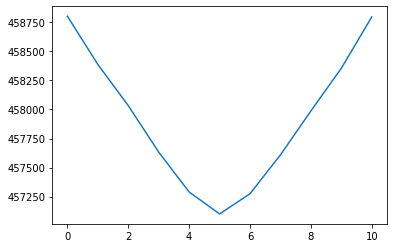

In [ ]:
ELBO_list = []
for p in p_list: 
  LAMBDA, GAMMA, PHI = p 
  elbo = compute_elbo(LAMBDA, GAMMA, PHI, train_articles, train_nonzero_idxs, C)
  ELBO_list.append(elbo) 
plt.plot(ELBO_list)

ELBO: 458802.54623959324
ELBO: 456143.7435779193
ELBO: 455488.15273919964
ELBO: 455111.12169067486
ELBO: 454898.34527409164
ELBO: 454829.2172014257
ELBO: 454901.57625159493
ELBO: 455117.4532279489
ELBO: 455497.0737213623
ELBO: 456153.5060485905
ELBO: 458796.8835886078


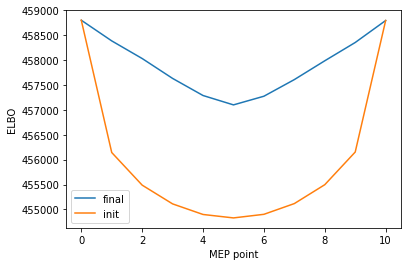

In [ ]:
plt.plot(ELBO_list,label = 'final')

p_list_init = init(theta1, theta2, N)
ELBO_list_init = []
for p in p_list_init: 
  LAMBDA, GAMMA, PHI = p 
  elbo = compute_elbo(LAMBDA, GAMMA, PHI, train_articles, train_nonzero_idxs, C)
  ELBO_list_init.append(elbo) 
plt.plot(ELBO_list_init ,label = 'init')
plt.xlabel("MEP point") 
plt.ylabel("ELBO")
plt.legend()

In [ ]:
p_list_train1 = p_list

In [ ]:
plt.style.use('seaborn-white')

In [ ]:
def generate_contour(theta_1, theta_2):
  LAMBDA_1, GAMMA_1, PHI_1 = theta_1
  LAMBDA_2, GAMMA_2, PHI_2 = theta_2

  interval = np.linspace(0,1,N+1)

  x = np.linspace(0, 5, 50)
  y = np.linspace(0, 5, 40)

  X, Y = np.meshgrid(x, y)
  Z = f(X, Y)
  
  p_list = []

  for i in interval:
    NEW_LAMBDA = (LAMBDA_2 - LAMBDA_1) * i + LAMBDA_1
    NEW_GAMMA = (GAMMA_2 - GAMMA_1) * i + GAMMA_1
    NEW_PHI = [(Phi_2 - Phi_1) * i + Phi_1 for (Phi_1,Phi_2) in zip(PHI_1,PHI_2)]
    p_list.append([NEW_LAMBDA, NEW_GAMMA, NEW_PHI]) 


  return p_list


###contour plot 

Dimensionality reduction of parameters into 2d 
- choose two orthogonal random directions in high dimension and project onto these two dimensions to obtain a 2d embedding

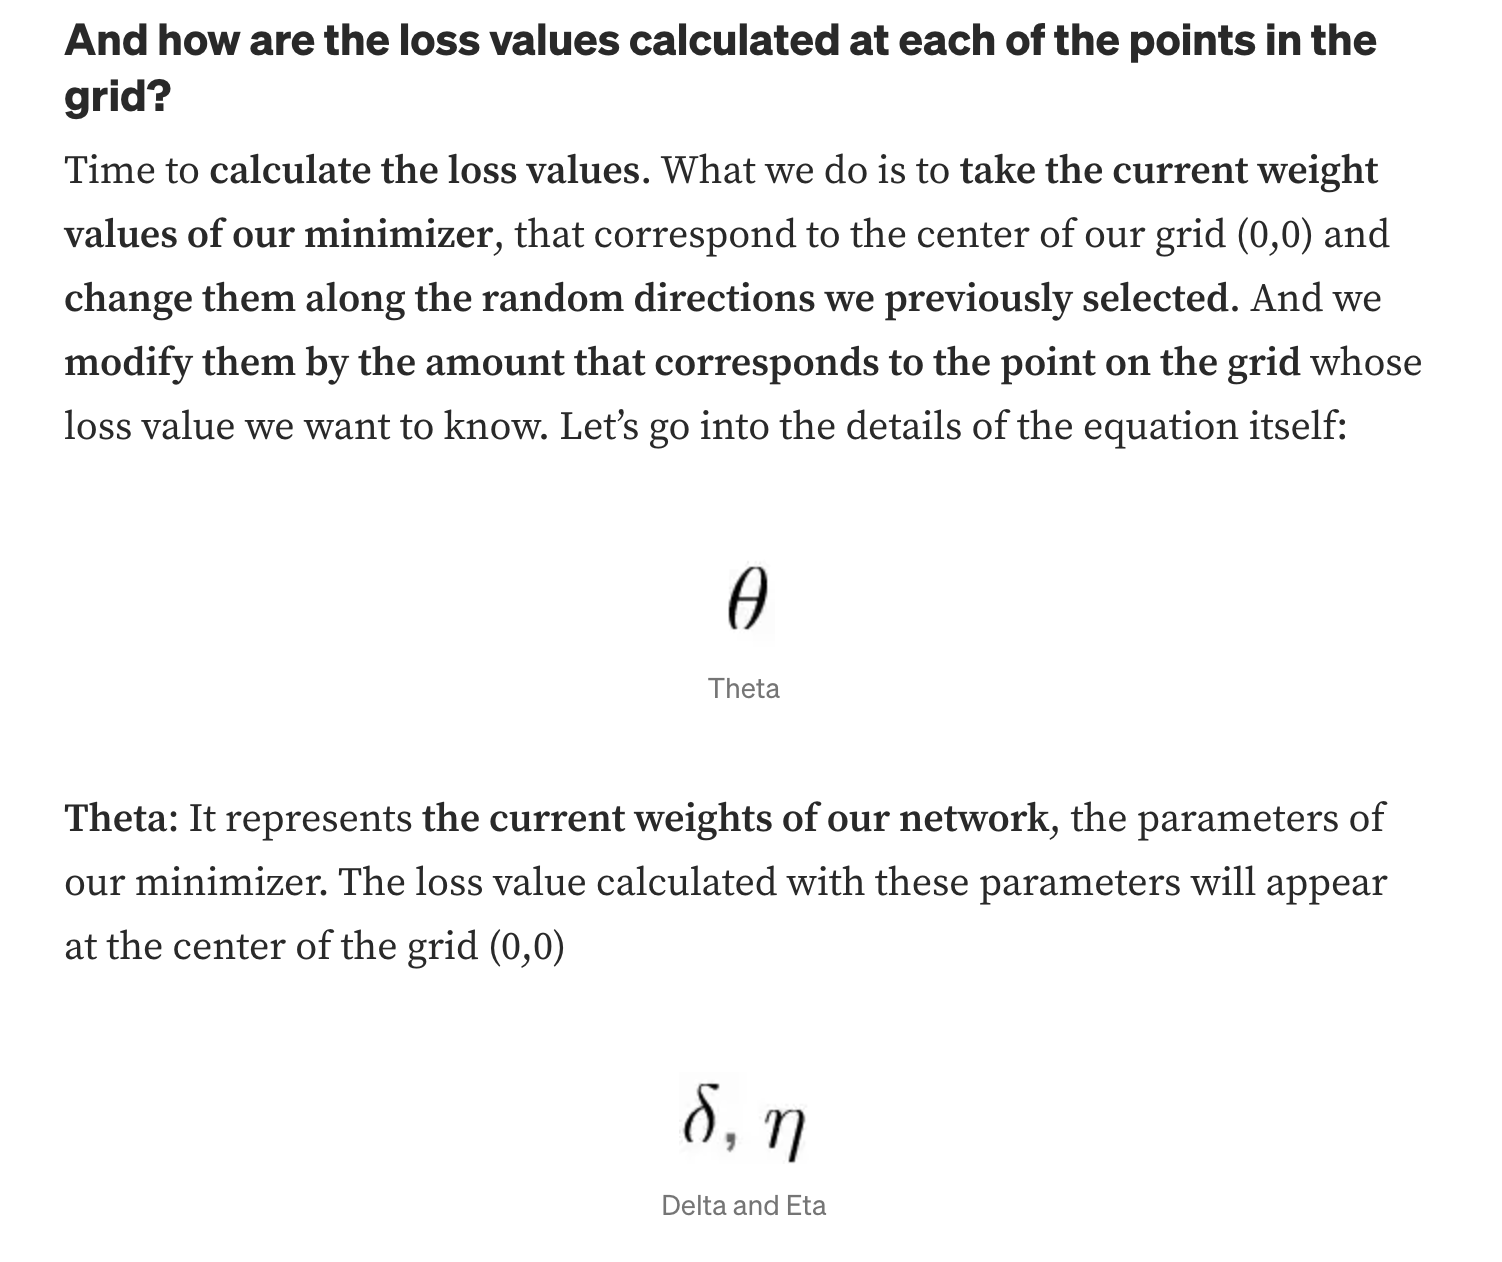

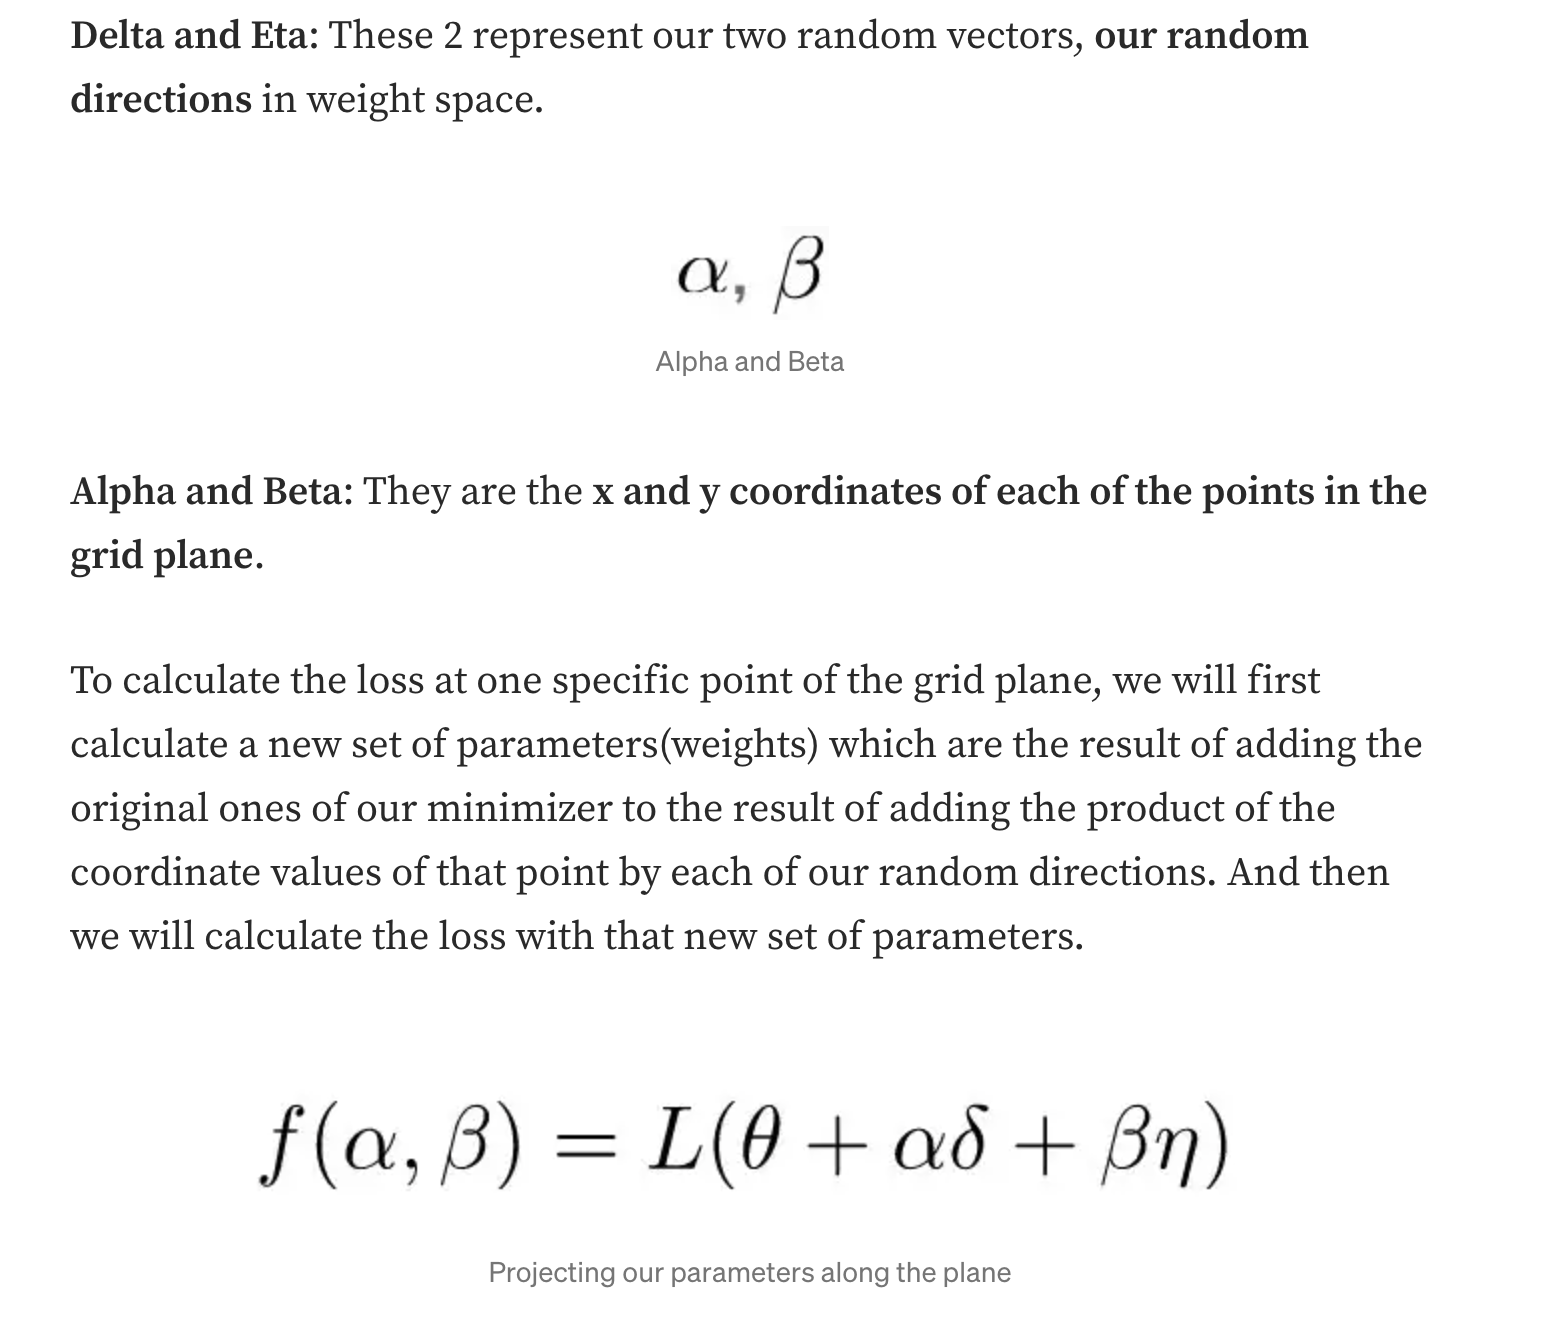

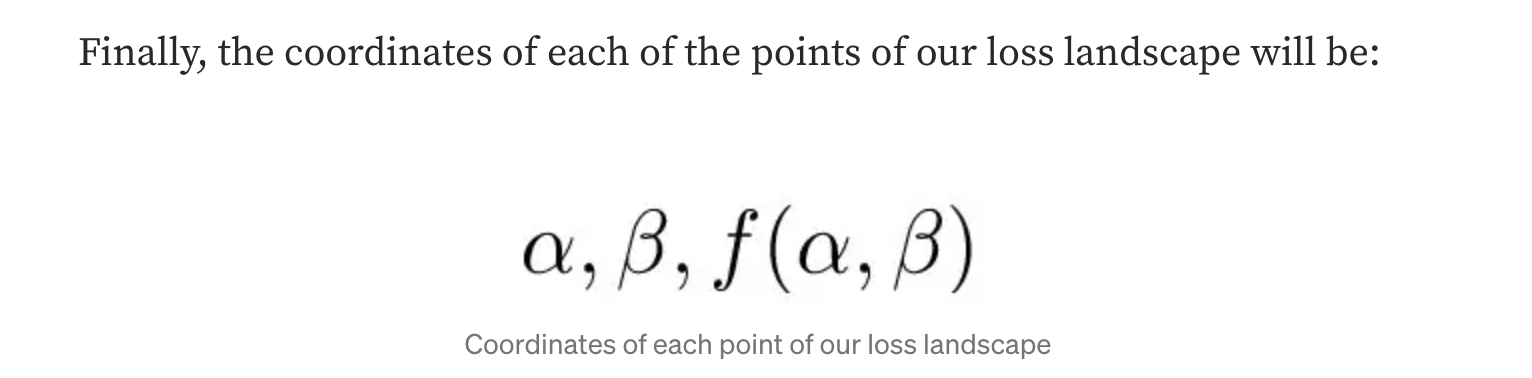

In [ ]:

#TODO 
def param_vector(p): 
  '''
  return a long vector p_vector given a set of parameters p 
  '''
  p_vector = None 
  return p_vector 


#TODO 
def param(p_vector): 
  ''' 
  return a set of parameters p given a long vector p_vector 
  ''' 

  p = None
  return p 

p1_vec = param_vector(theta1)
p2_vec = param_vector(theta2)
center = p1_vec + 0.5*(p2_vec-p1_vec)

len = p1_vec.shape[0]
#two random directions 
d1 = np.random.normal(0, 1, len)
d1 = d1/np.norm(d1) 
d2 = np.random.normal(0, 1, len) 
d2 = d2/np.norm(d2)  

precision = 10
loss_surface = np.zeros((precision,precision))
for i in len(precision):
  for j in len(precision): 
    LAMBDA, GAMMA, PHI = param(center + i*d1 + j*d2)
    loss_surface[i,j] = compute_elbo(LAMBDA, GAMMA, PHI,train_articles, train_nonzero_idxs)
    j+=1
  i+=1

#TODO 
#plot loss_surface 


#TODO 
#plots points (p_list) on the loss surface by first centering the points and then projecting them onto d1 and d2 

In [ ]:
X, Y = np.meshgrid(np.linspace(-2, 1, 101), np.linspace(-1, 1, 101))
Z = np.exp(X+3*Y-0.1)+np.exp(X-3*Y-0.1)+np.exp(-X-0.1)

x = [pt[0,0] for pt in pt_list]
y = [pt[1,0] for pt in pt_list]
n = [num for num in range(len(pt_list))]

fig, ax = plt.subplots(figsize=(6,6))

ax.contour(X, Y, Z,levels = 50)

#fig, ax = plt.subplots()
ax.scatter(x, y)

ax.plot(x,y)
for i, txt in enumerate(n):
  ax.annotate(txt, (x[i], y[i]))

plt.show()

###out of sample performance


In [ ]:
elbo_list = []
for p in p_list: 
  LAMBDA, GAMMA, PHI = p 
  elbo = compute_elbo(LAMBDA, GAMMA, PHI, test_articles, test_nonzero_idxs, C)
  elbo_list.append(elbo) 

IndexError: ignored

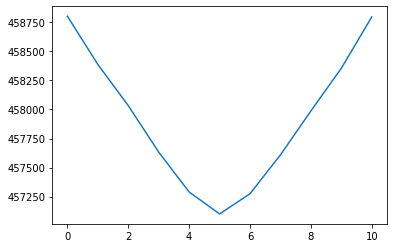

In [ ]:
plt.plot(elbo_list)

### Dec 1 night 

In [ ]:
T = 100
N = 50
p_list = init(theta1, theta2, N)
k = 1
lr = 5*1e-2

for t in range (T):
  for i in range (1,N+1):
    print(i)
    F_L_lmbda, F_L_gamma, F_L_phi = F_L(i, p_list,train_articles, train_nonzero_idxs, C) 
    F_s_lmbda, F_s_gamma, F_s_phi = F_s(i, k, p_list)
    LAMBDA, GAMMA, PHI = p_list[i] 
    
    LAMBDA = LAMBDA + lr * (-F_L_lmbda + F_s_lmbda)
    GAMMA = GAMMA + lr * (-F_L_gamma + F_s_gamma)
    PHI = [phi + lr * (-f_l_phi + f_s_phi) for (phi, f_l_phi, f_s_phi) in zip(PHI, F_L_phi, F_s_phi)]
    p_list[i] = [LAMBDA, GAMMA, PHI ]

1
ELBO: -133324.0013080544
ELBO: -120110.04764006153


100%|██████████| 214/214 [00:05<00:00, 42.63it/s]


Updating LAMBDA


100%|██████████| 5/5 [00:00<00:00, 44.63it/s]


2
ELBO: -135054.04168727368
ELBO: nan


100%|██████████| 214/214 [00:05<00:00, 42.36it/s]


Updating LAMBDA


100%|██████████| 5/5 [00:00<00:00, 33.77it/s]


3
ELBO: -136289.80676921576
ELBO: -134160.03425489177


100%|██████████| 214/214 [00:04<00:00, 43.16it/s]


Updating LAMBDA


100%|██████████| 5/5 [00:00<00:00, 39.08it/s]


4
ELBO: -137248.10626465193
ELBO: -134996.0367650784


 44%|████▍     | 94/214 [00:02<00:02, 42.64it/s]


KeyboardInterrupt: ignored

###random

In [ ]:
theta_2 = [np.ones((3,5)), np.ones((5,7)), np.ones((7,9))]
theta_1 = [np.zeros((3,5)), np.zeros((5,7)), np.zeros((7,9))]

p_list =  init(theta_1, theta_2, N=10)
F_s(5, 1, p_list)

[array([[-0.1, -0.1, -0.1, -0.1, -0.1],
        [-0.1, -0.1, -0.1, -0.1, -0.1],
        [-0.1, -0.1, -0.1, -0.1, -0.1]]),
 array([[-0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1],
        [-0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1],
        [-0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1],
        [-0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1],
        [-0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1]]),
 array([[-0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1],
        [-0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1],
        [-0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1],
        [-0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1],
        [-0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1],
        [-0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1],
        [-0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1]])]

In [ ]:
p_list

[[array([[0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.]]), array([[0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0.]]), array([[0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0.]])],
 [array([[0.1, 0.1, 0.1, 0.1, 0.1],
         [0.1, 0.1, 0.1, 0.1, 0.1],
         [0.1, 0.1, 0.1, 0.1, 0.1]]),
  array([[0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1],
         [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1],
         [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1],
         [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1],
         [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]]),
  array([[0.1, 0.1, 0.1, 0.1, 0.1, 0.1

###Dec 11 (discard)

In [ ]:
!pip install tomotopy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 16.5 MB 269 kB/s 


In [ ]:
import tomotopy as tp
mdl = tp.LDAModel(k=20)
for line in open('sample.txt'):
    mdl.add_doc(line.strip().split())

for i in range(0, 100, 10):
    mdl.train(10)
    print('Iteration: {}\tLog-likelihood: {}'.format(i, mdl.ll_per_word))

for k in range(mdl.k):
    print('Top 10 words of topic #{}'.format(k))
    print(mdl.get_topic_words(k, top_n=10))

mdl.summary()